In [1]:
# data analysis and data wrangling
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
# preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF


## Natural Processing Language
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk

# other
from imp import reload

# import platform
import warnings
import platform
import pathlib
import pprint
import string
import json
import time
import re
import os

In [ ]:
def path_to_work(end_directory: str='notebooks'):
    curr_dir = os.path.dirname(os.path.realpath ("__file__")) 
    
    if curr_dir.endswith(end_directory):
        os.chdir('..')
        return f'Change directory to: {curr_dir}'
    
    return f'Current working directory: {curr_dir}'

In [ ]:
path_to_work('notebooks')

'Current working directory: /content'

In [ ]:
%%time

raw_data = open('100.txt', mode='r').read()

CPU times: user 8.34 ms, sys: 16 ms, total: 24.3 ms
Wall time: 25.5 ms


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
count_rows = raw_data.count('\n')
unique_char = sorted(set(raw_data))
list_words_tokens = word_tokenize(raw_data)

In [ ]:
print(f'Total rows: {count_rows}')
print(f'Total tokens: {len(list_words_tokens)}')
print(f'Total characters: {len(raw_data)}')
print(f'Total unique character: {len(unique_char)}')
print(f'\nSample:\n{raw_data[:500]}')

Total rows: 124788
Total tokens: 1134704
Total characters: 5465129
Total unique character: 91

Sample:
The Project Gutenberg EBook of The Complete Works of William Shakespeare, by
William Shakespeare

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org

** This is a COPYRIGHTED Project Gutenberg eBook, Details Below **
**     Please follow the copyright guidelines in this file.     **

Title: The Comple


In [ ]:
print('characters:\n', unique_char)

characters:
 ['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '}', '~']


In [ ]:
def remove_unnecessary_text(str_shakespeare_full: str, int_last_line: int):
    # Remove any lines that start with a "<" followed by eight lines that each end with a newline character.
    str_pre_clean = re.sub("<(.+)\n(.+)\n(.+)\n(.+)\n(.+)\n(.+)\n(.+)\n(.+)", '', str_shakespeare_full)
    
    # Split the text into individual lines and only keep the first `int_last_line` lines.
    slines = str_pre_clean.splitlines(keepends=True)[1:int_last_line]
    
    # Count the number of times the author's name appears in the text.
    author_count = 0
    
    # The variable 'start_line' will keep track of the index of the first line of the first play.
    start_line = 1
    
    for i, row in enumerate(slines):
        # If the current row contains the text "by William Shakespeare", increment the author count.
        if 'by William Shakespeare' in row: 
            author_count += 1
        
        # If we've seen the author's name twice, we've passed the title and the "by William Shakespeare" line.
        # Set 'start_line' to be the index of the row two lines before the current row (the first line of the first play).
        if author_count == 2:
            start_line = i - 5
            break
    
    # Return all lines starting from the first line of the first play.
    return slines[(start_line + 2):]

In [ ]:
data_pre_cleansing = remove_unnecessary_text(str_shakespeare_full=raw_data,
                                             int_last_line=122343)
data_pre_cleansing[1300]

'    Which, as your due, time claims, he does acknowledge;\n'

In [ ]:
data_cleansing = [x.lstrip() for x in data_pre_cleansing]
data_cleansing[1300]

'Which, as your due, time claims, he does acknowledge;\n'

In [ ]:
data_cleansing_txt = " ".join(str(x) for x in data_cleansing)

with open('data_preprocess.txt', mode='w') as w:
    w.write(str(data_cleansing_txt))

In [ ]:
char2idx = {u:i for i, u in enumerate(unique_char)}
idx2char = np.array(unique_char)

In [ ]:
#Create bag of word with regard to list of word and lenght of 
def create_bag_of_words(list_words: list, ngram: int) -> list:
    vec = CountVectorizer(ngram_range=(ngram, ngram),
                          stop_words="english",
                          lowercase=True)
    
    bag_of_words = vec.fit_transform(list_words)
    sum_words = bag_of_words.sum(axis=0)

    return [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

In [ ]:
def tfidf_vectorizer(documents, total_features: int):
    # Initialize a TfidfVectorizer object with specified parameters.
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95,
                                       min_df=2,
                                       max_features=total_features,
                                       stop_words='english')
    # Apply the TfidfVectorizer to the documents and transform them into a TF-IDF matrix.
    tfidf = tfidf_vectorizer.fit_transform(documents)
    # Extract the feature names from the TfidfVectorizer.
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()

    # Return the TfidfVectorizer, the TF-IDF matrix, and the feature names.
    return tfidf_vectorizer, tfidf, tfidf_feature_names

def count_vectorizer(documents, total_features: int):
    # Initialize a CountVectorizer object with specified parameters.
    tf_vectorizer = CountVectorizer(max_df=0.95, 
                                    min_df=2,
                                    max_features=total_features,
                                    stop_words='english')
    # Apply the CountVectorizer to the documents and transform them into a count matrix.
    tf = tf_vectorizer.fit_transform(documents)
    # Extract the feature names from the CountVectorizer.
    tf_feature_names = tf_vectorizer.get_feature_names()

    # Return the CountVectorizer, the count matrix, and the feature names.
    return tf_vectorizer, tf, tf_feature_names

In [ ]:
total_features = 100000
no_top_words = 20

In [ ]:
tfidf_vectorizer, tfidf, tfidf_feature_names = tfidf_vectorizer(data_cleansing,
                                                                total_features)
tf_vectorizer, tf, tf_feature_names = count_vectorizer(data_cleansing, 
                                                       total_features)

In [ ]:
bag_of_words = create_bag_of_words(list_words=data_cleansing, ngram=1)

In [ ]:
def get_top_n_words(bag_of_words, n_elements) -> list:
    return sorted(bag_of_words, key = lambda x: x[1], reverse=True)[:n_elements]

In [ ]:
top_20_words = get_top_n_words(bag_of_words, 20)
df_unigram = pd.DataFrame(top_20_words, columns = ['word' , 'count'])
df_unigram.head()

,word,count
0,thou,5307
1,thy,3745
2,shall,3538
3,lord,3093
4,king,3039


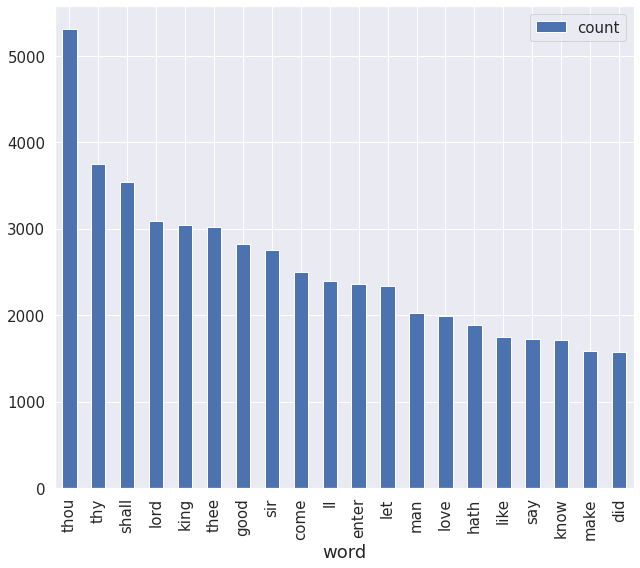

In [ ]:
import matplotlib.pyplot as mp

df_unigram.plot(x='word', y='count', kind="bar", figsize=(9, 8))
mp.show()

In [ ]:
bag_of_words_bigram = create_bag_of_words(data_cleansing, ngram=2)

In [ ]:
top_20_words_bigram = get_top_n_words(bag_of_words_bigram, 20)
df_bigram = pd.DataFrame(top_20_words_bigram, columns = ['word' , 'count'])
df_bigram.head()

,word,count
0,thou art,501
1,king henry,399
2,thou hast,354
3,king richard,277
4,st thou,249


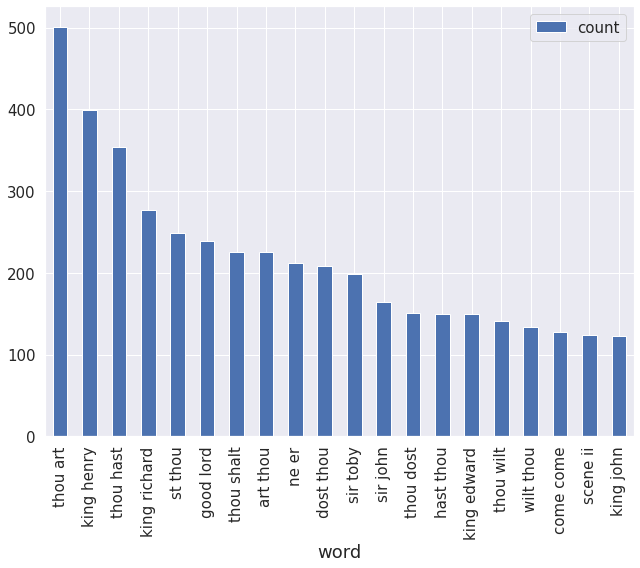

In [ ]:
df_bigram.plot(x='word', y='count', kind="bar", figsize=(9, 8))
mp.show()

**Centralized**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# load the Shakespeare's preprocessed dataset
text = open('data_preprocess.txt', 'r').read()

# encode the characters as integers
chars = sorted(list(set(text)))
char_to_int = {char: i for i, char in enumerate(chars)}
int_to_char = {i: char for i, char in enumerate(chars)}

# define the number of characters in the sequence and the vocabulary size
seq_length = 100
vocab_size = len(chars)

# create inputs and targets from the text
inputs = []
targets = []
for i in range(0, len(text) - seq_length):
    inputs.append([char_to_int[char] for char in text[i:i + seq_length]])
    targets.append(char_to_int[text[i + seq_length]])
    
# convert inputs and targets to tensors
inputs = torch.LongTensor(inputs).transpose(0, 1)
targets = torch.LongTensor(targets)

In [3]:
batch_size = 10
num_batches = len(inputs) // batch_size

# divide the inputs and targets into batches
inputs = inputs.split(batch_size, dim=1)
targets = targets.split(batch_size)

# define the LSTM network with an embedding layer
class LSTM(nn.Module):
    def __init__(self, vocab_size, seq_length, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x[-1, :, :])
        return x

# initialize the network
hidden_size = 256
num_layers = 2
model = LSTM(vocab_size, seq_length, hidden_size, num_layers)

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# train the network
num_epochs = 20
losses_centralized = []
#accs = []

for epoch in range(num_epochs):
    total_loss, total_accuracy, total_total = 0, 0, 0
    for i in range(num_batches):
        optimizer.zero_grad()
        outputs = model(inputs[i])
        loss = criterion(outputs, targets[i])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        #total_accuracy += torch.sum(torch.argmax(inputs_train[i] == targets_train[i])) / torch.numel(targets_train[i])
        #total_accuracy += torch.sum(torch.argmax(outputs, dim=2) == targets[i]).item()
        #total_total += targets[i].numel()
        #total_accuracy += total_accuracy / total_total
    
    #accs.append(total_accuracy / num_batches)
    losses_centralized.append(total_loss / num_batches)
    #train_accs.append(total_accuracy / num_batches_itr)


    if (epoch + 1) % 5 == 0:
        print(f"Epoch: {epoch + 1}/{num_epochs}, Loss: {losses_centralized[-1]:.4f}")
        #print(f"Epoch: {epoch + 1}/{num_epochs}, Train-Accuracy: {train_accs[-1]:.4f}, Test-Accuracy:{test_accs[-1]:.4f}")

Epoch: 5/20, Loss: 2.4455
Epoch: 10/20, Loss: 1.3092
Epoch: 15/20, Loss: 0.4917
Epoch: 20/20, Loss: 0.1950


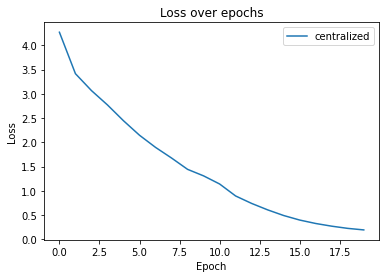

In [4]:
# plot the loss
plt.plot(losses_centralized, label='centralized')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# load the Shakespeare's preprocessed dataset
text = open('data_preprocess.txt', 'r').read()

# encode the characters as integers
chars = sorted(list(set(text)))
char_to_int = {char: i for i, char in enumerate(chars)}
int_to_char = {i: char for i, char in enumerate(chars)}

# define the number of characters in the sequence and the vocabulary size
seq_length = 100
vocab_size = len(chars)

# create inputs and targets from the text
inputs = []
targets = []
for i in range(0, len(text) - seq_length):
    inputs.append([char_to_int[char] for char in text[i:i + seq_length]])
    targets.append(char_to_int[text[i + seq_length]])
    
# convert inputs and targets to tensors
inputs = torch.LongTensor(inputs).transpose(0, 1)
targets = torch.LongTensor(targets)

In [ ]:
train_percent = 0.8
train_size = int(train_percent * inputs.shape[0])
inputs_train, inputs_test = inputs[:train_size, :], inputs[train_size:, :]
targets_train, targets_test = targets[:train_size], targets[train_size:]

batch_size = 10
num_batches_itr = len(inputs_train) // batch_size
num_batches_ite = len(inputs_test) // batch_size

# divide the inputs and targets into batches
#inputs = inputs.split(batch_size, dim=1)
#targets = targets.split(batch_size)

inputs_train = inputs_train.split(batch_size, dim=1)
inputs_test = inputs_test.split(batch_size, dim=1)
targets_train = targets_train.split(batch_size)
targets_test = targets_test.split(batch_size)

# define the LSTM network with an embedding layer
class LSTM(nn.Module):
    def __init__(self, vocab_size, seq_length, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x[-1, :, :])
        return x

# initialize the network
hidden_size = 256
num_layers = 2
model = LSTM(vocab_size, seq_length, hidden_size, num_layers)

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# train the network
num_epochs = 20
train_losses = []
#train_accs = []
test_losses = []
#test_accs = []
for epoch in range(num_epochs):
    total_loss, total_accuracy = 0, 0
    for i in range(num_batches_itr):
        optimizer.zero_grad()
        outputs = model(inputs_train[i])
        loss = criterion(outputs, targets_train[i])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        #total_accuracy += torch.sum(torch.argmax(inputs_train[i] == targets_train[i])) / torch.numel(targets_train[i])
    train_losses.append(total_loss / num_batches_itr)
    #train_accs.append(total_accuracy / num_batches_itr)

    with torch.no_grad():
        tot_loss,tot_acc = 0, 0
        for i in range(num_batches_ite):
            outputs = model(inputs_test[i])
            loss = criterion(outputs, targets_test[i])
            tot_loss += loss.item()
            #tot_acc += torch.sum(torch.argmax(inputs_test[i] == targets_test[i])) / torch.numel(targets_test[i])
        test_losses.append(tot_loss / num_batches_ite)
        #test_accs.append(tot_acc / num_batches_ite)
    if (epoch + 1) % 5 == 0:
        print(f"Epoch: {epoch + 1}/{num_epochs}, Train-Loss: {train_losses[-1]:.4f}, Test-Loss: {test_losses[-1]:.4f}")
        #print(f"Epoch: {epoch + 1}/{num_epochs}, Train-Accuracy: {train_accs[-1]:.4f}, Test-Accuracy:{test_accs[-1]:.4f}")

Epoch: 5/20, Train-Loss: 2.6603, Test-Loss: 4.0982
Epoch: 10/20, Train-Loss: 1.3556, Test-Loss: 4.5817
Epoch: 15/20, Train-Loss: 0.4672, Test-Loss: 5.6767
Epoch: 20/20, Train-Loss: 0.1855, Test-Loss: 6.6214


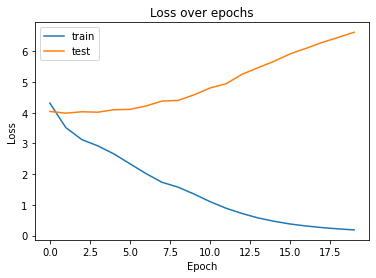

In [ ]:
# plot the loss
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

**FedAVG**

In [6]:
#import some libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
import matplotlib.pyplot as plt
import copy

In [7]:
#load preprocessed dataset
with open('data_preprocess.txt', 'r') as f:
    text = f.read()
if not text:
    text = "default text"
text = str(text)
chars = list(text)

In [8]:
#define number of clients and split data between clients
n_clients = 10
client_texts = np.array_split(chars, n_clients)

In [9]:
#Amount of each client that should train on
for i, client_text in enumerate(client_texts):
    print(f"Client {i}: {len(client_text)}")

Client 0: 486431
Client 1: 486431
Client 2: 486431
Client 3: 486431
Client 4: 486431
Client 5: 486430
Client 6: 486430
Client 7: 486430
Client 8: 486430
Client 9: 486430


In [10]:
class ShakespeareDataset(Dataset):
    def __init__(self, text, seq_length):
        self.seq_length = seq_length
        # create a set of unique characters in the text and sort them
        chars = sorted(list(set(text)))
        # create dictionaries to map between characters and their indices
        self.char_to_idx = {ch: i for i, ch in enumerate(chars)}
        self.idx_to_char = {i: ch for i, ch in enumerate(chars)}
        # convert the text to a list of indices representing each character
        self.data = self._prepare_data(text)
    
    def _prepare_data(self, text):
        # convert the text to a list of indices representing each character
        data = [self.char_to_idx[ch] for ch in text]
        return data
    
    def __getitem__(self, idx):
        # calculate the start and end indices of the current sequence
        start_idx = idx * self.seq_length
        end_idx = (idx + 1) * self.seq_length + 1
        # get the input sequence and target sequence for the current example
        input_seq = self.data[start_idx:end_idx-1]
        target_seq = self.data[start_idx+1:end_idx]
        # convert the input and target sequences to PyTorch tensors and return them
        return torch.LongTensor(input_seq), torch.LongTensor(target_seq)
    
    def __len__(self):
        # calculate the number of examples in the dataset
        return len(self.data) // self.seq_length

In [11]:
class ShakespeareLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(ShakespeareLSTM, self).__init__()
        # create an embedding layer that maps from character indices to embedding vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # create an LSTM layer with input size of embedding_dim and hidden size of hidden_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        # create a linear layer that maps from hidden_dim to vocab_size (i.e., the size of the vocabulary)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x, hidden):
        # pass the input tensor x through the embedding layer to get the corresponding embeddings
        x = self.embedding(x)
        # pass the embeddings and the hidden state to the LSTM layer to get the output and the new hidden state
        x, hidden = self.lstm(x, hidden)
        # pass the output through the linear layer to get the final prediction
        x = self.fc(x)
        # return the final prediction and the new hidden state
        return x, hidden

In [12]:
def train(model, dataloader, criterion, optimizer, device):
    # set the model to training mode
    model.train()
    # initialize some variables to keep track of the total loss and accuracy over the epoch
    total_loss = 0.0
    total_correct = 0
    total_total = 0
    
    # loop over the batches in the dataloader
    for inputs, targets in dataloader:
        # move the inputs and targets to the device (e.g., GPU) if necessary
        inputs, targets = inputs.to(device), targets.to(device)
        # zero out the gradients in the optimizer
        optimizer.zero_grad()
        # run the inputs through the model to get the outputs
        outputs, _ = model(inputs, None)
        # calculate the loss between the outputs and the targets
        loss = criterion(outputs.view(-1, outputs.size(2)), targets.view(-1))
        # backpropagate the loss through the model to compute the gradients
        loss.backward()
        # take an optimizer step to update the model parameters
        optimizer.step()
        
        # update the total loss and accuracy variables
        total_loss += loss.item()
        total_correct += torch.sum(torch.argmax(outputs, dim=2) == targets).item()
        total_total += targets.numel()
    
    # compute the average loss and accuracy over the epoch
    avg_loss = total_loss / len(dataloader)
    avg_acc = total_correct / total_total
    # return the average loss and accuracy
    return avg_loss, avg_acc

In [13]:
def federated_averaging(model, client_datasets, num_epochs, batch_size, lr, device):
    # Initialize global weights with the current model state
    global_weights = model.state_dict()
    
    # Define loss function and empty lists to store losses and accuracies for each epoch
    criterion = nn.CrossEntropyLoss()
    losses = []
    accuracies = []
    
    # Train the model for the specified number of epochs
    for epoch in range(num_epochs):
        client_weights = []
        
        # Iterate over the client datasets and train a local model on each one
        for client_text in client_texts:
            # Create a dataset and dataloader for the current client
            client_dataset = ShakespeareDataset(client_text, seq_length)
            client_dataloader = DataLoader(client_dataset, batch_size=batch_size, shuffle=True)
            
            # Create a local copy of the model and load the global weights
            client_model = ShakespeareLSTM(vocab_size, embedding_dim, hidden_dim).to(device)
            client_model.load_state_dict(global_weights)
            
            # Train the local model for one epoch using the client dataset
            client_optimizer = optim.Adam(client_model.parameters(), lr=lr)
            avg_loss, avg_acc = train(client_model, client_dataloader, criterion, client_optimizer, device)
            
            # Record the loss and accuracy for the current client
            losses.append(avg_loss)
            accuracies.append(avg_acc)
            
            # Save the local model weights
            client_weights.append(client_model.state_dict())
        
        # Update the global weights by averaging the local model weights
        global_weights = average_weights(client_weights)
        model.load_state_dict(global_weights)
        
        # Print the loss and accuracy for the final client in the last epoch
        print(f"Epoch {epoch+1}:")
        print(f"Training loss: {avg_loss:.4f}")
        print(f"Training accuracy: {avg_acc:.4f}")
        
    # Return the lists of losses and accuracies for each epoch
    return losses, accuracies

In [14]:
#additional function for calculate average_weights
def average_weights(weights):
    avg_weights = {}
    for name in weights[0]:
        avg_weights[name] = sum(w[name] for w in weights) / len(weights)
    return avg_weights

In [15]:
#set hyperparameters
seq_length = 100
chars = sorted(list(set(text)))
vocab_size = len(chars)
embedding_dim = 64
hidden_dim = 256
num_epochs = 10
batch_size = 10
lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# train model
train_dataset = ShakespeareDataset(text, seq_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = ShakespeareLSTM(vocab_size, embedding_dim, hidden_dim).to(device)
clients_loss_fedavg_iid, cliets_acc_fedavg_iid = federated_averaging(model, client_texts, num_epochs, batch_size, lr, device)

Epoch 1:
Training loss: 2.6930
Training accuracy: 0.2581
Epoch 2:
Training loss: 2.5760
Training accuracy: 0.2651
Epoch 3:
Training loss: 2.5456
Training accuracy: 0.2670
Epoch 4:
Training loss: 2.5340
Training accuracy: 0.2681
Epoch 5:
Training loss: 2.5268
Training accuracy: 0.2687
Epoch 6:
Training loss: 2.5219
Training accuracy: 0.2684
Epoch 7:
Training loss: 2.5188
Training accuracy: 0.2693
Epoch 8:
Training loss: 2.5168
Training accuracy: 0.2690
Epoch 9:
Training loss: 2.5149
Training accuracy: 0.2690
Epoch 10:
Training loss: 2.5131
Training accuracy: 0.2692


In [16]:
#store losses and acuraccies per batches and plot them 
losses_fedavg_iid = []
accs_fedavg_iid = []
criterion = nn.CrossEntropyLoss()

for inputs, targets in train_dataloader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs, _ = model(inputs, None)
    loss = criterion(outputs.view(-1, outputs.size(2)), targets.view(-1))
    losses_fedavg_iid.append(loss.item())
    accs_fedavg_iid.append(torch.sum(torch.argmax(outputs, dim=2) == targets).item() / targets.numel())

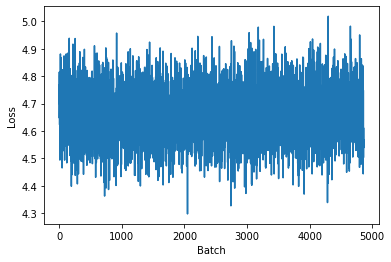

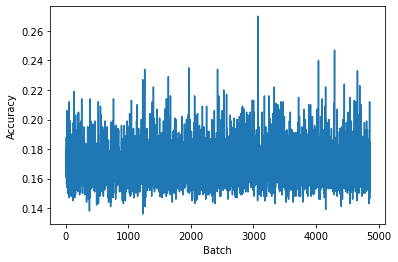

In [17]:
plt.plot(losses_fedavg_iid)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

plt.plot(accs_fedavg_iid)
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.show()

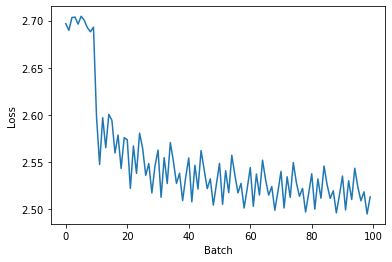

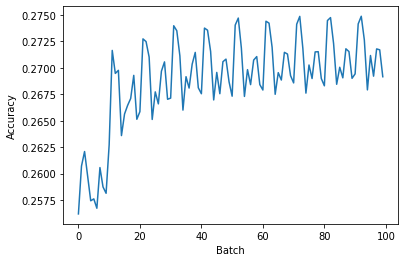

In [18]:
#plot total model loss and accuracy
plt.plot(clients_loss_fedavg_iid)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

plt.plot(cliets_acc_fedavg_iid)
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.show()

**Non-IID distribution**

In [19]:
def split_data(text, n_clients):
    # Compute indices for non-IID data distribution
    n_samples = len(text)
    client_indices = []
    for i in range(n_clients):
        start_idx = (i * n_samples) // n_clients
        end_idx = ((i + 1) * n_samples) // n_clients
        client_indices.append(np.arange(start_idx, end_idx))

    # Assign each set of indices to a client
    client_texts = []
    for indices in client_indices:
        client_text = ''.join([text[i] for i in indices])
        client_texts.append(client_text)

    return client_texts

In [20]:
import random
import math


with open('data_preprocess.txt', 'r') as f:
    text = f.read()
if not text:
    text = "default text"
text = str(text)
char_noniid = list(text)

num_clients = 10
# Define the non-IID distribution of documents per client
docs_per_client = [10, 15, 5, 20, 25, 10, 5, 15, 5, 10]
# Determine the total number of documents in the dataset
total_docs = len(char_noniid)
# Shuffle the dataset randomly to ensure that the distribution is not biased
random.shuffle(char_noniid)
# Calculate the number of documents to assign to each client
num_docs_per_client = []
for i in range(num_clients):
    num_docs = math.floor(docs_per_client[i] / sum(docs_per_client) * total_docs)
    num_docs_per_client.append(num_docs)
# Assign documents to each client
client_texts = []
start = 0
for i in range(num_clients):
    end = start + num_docs_per_client[i]
    client_texts.append(char_noniid[start:end])
    start = end

In [21]:
for i, client_text in enumerate(client_texts):
    print(f"Client {i}: {len(client_text)}")

Client 0: 405358
Client 1: 608038
Client 2: 202679
Client 3: 810717
Client 4: 1013396
Client 5: 405358
Client 6: 202679
Client 7: 608038
Client 8: 202679
Client 9: 405358


In [22]:
seq_length = 100
chars = sorted(list(set(text)))
vocab_size = len(chars)
embedding_dim = 64
hidden_dim = 256
num_epochs = 10
batch_size = 10
lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = ShakespeareDataset(text, seq_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = ShakespeareLSTM(vocab_size, embedding_dim, hidden_dim).to(device)
clients_loss_fedavg_noniid, cliets_acc_fedavg_noniid = federated_averaging(model, client_texts, num_epochs, batch_size, lr, device)

Epoch 1:
Training loss: 3.3182
Training accuracy: 0.1848
Epoch 2:
Training loss: 3.2784
Training accuracy: 0.1864
Epoch 3:
Training loss: 3.2778
Training accuracy: 0.1864
Epoch 4:
Training loss: 3.2773
Training accuracy: 0.1864
Epoch 5:
Training loss: 3.2771
Training accuracy: 0.1864
Epoch 6:
Training loss: 3.2768
Training accuracy: 0.1864
Epoch 7:
Training loss: 3.2765
Training accuracy: 0.1864
Epoch 8:
Training loss: 3.2769
Training accuracy: 0.1864
Epoch 9:
Training loss: 3.2769
Training accuracy: 0.1864
Epoch 10:
Training loss: 3.2769
Training accuracy: 0.1864


In [23]:
losses_fedavg_noniid = []
accs_fedavg_noniid = []
criterion = nn.CrossEntropyLoss()

for inputs, targets in train_dataloader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs, _ = model(inputs, None)
    loss = criterion(outputs.view(-1, outputs.size(2)), targets.view(-1))
    losses_fedavg_noniid.append(loss.item())
    accs_fedavg_noniid.append(torch.sum(torch.argmax(outputs, dim=2) == targets).item() / targets.numel())

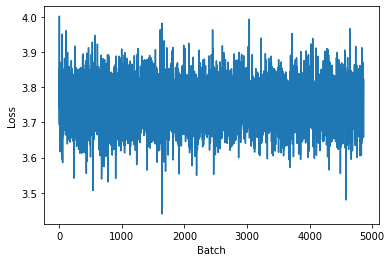

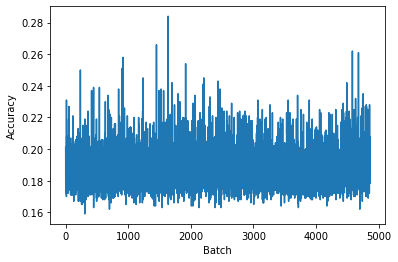

In [24]:
plt.plot(losses_fedavg_noniid)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

plt.plot(accs_fedavg_noniid)
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.show()

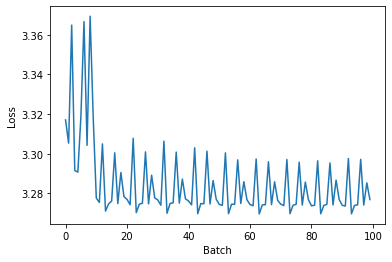

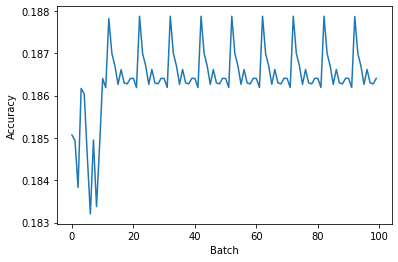

In [25]:
plt.plot(clients_loss_fedavg_noniid)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

plt.plot(cliets_acc_fedavg_noniid)
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.show()

**Compare IID and Non-IID distribution results in FedAVG**

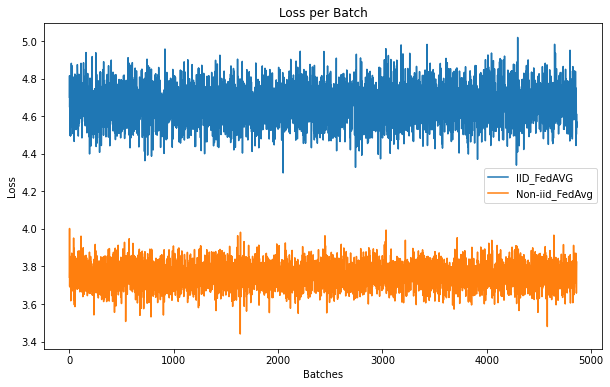

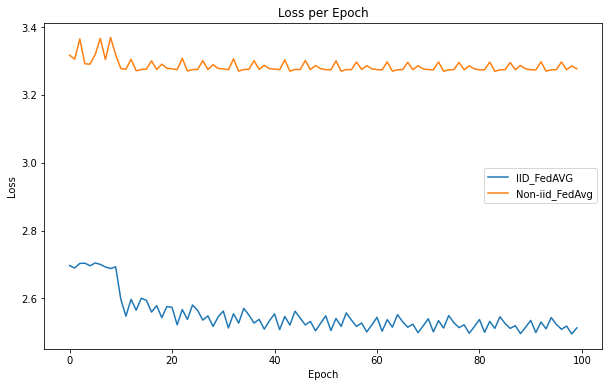

In [26]:
plt.figure(figsize=(10,6))
plt.plot(losses_fedavg_iid, label='IID_FedAVG')
plt.plot(losses_fedavg_noniid, label='Non-iid_FedAvg')
plt.title('Loss per Batch')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(clients_loss_fedavg_iid, label='IID_FedAVG')
plt.plot(clients_loss_fedavg_noniid, label='Non-iid_FedAvg')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

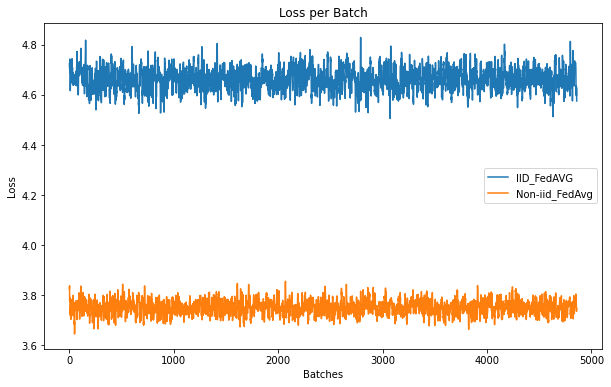

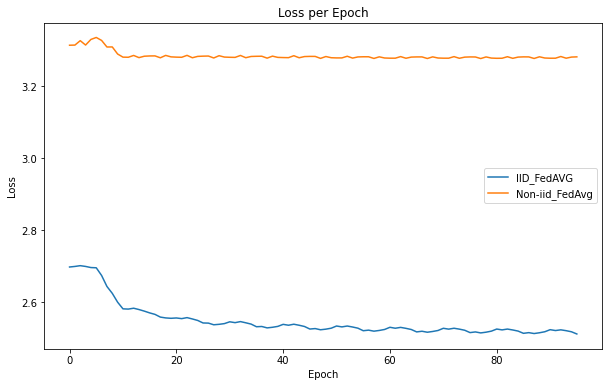

In [27]:
#just same as befor plot just np.convolve used here
plt.figure(figsize=(10,6))
plt.plot(np.convolve(losses_fedavg_iid , np.ones(5)/5, mode='valid'), label='IID_FedAVG')
plt.plot(np.convolve(losses_fedavg_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedAvg')
plt.title('Loss per Batch')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(np.convolve(clients_loss_fedavg_iid , np.ones(5)/5, mode='valid'), label='IID_FedAVG')
plt.plot(np.convolve(clients_loss_fedavg_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedAvg')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

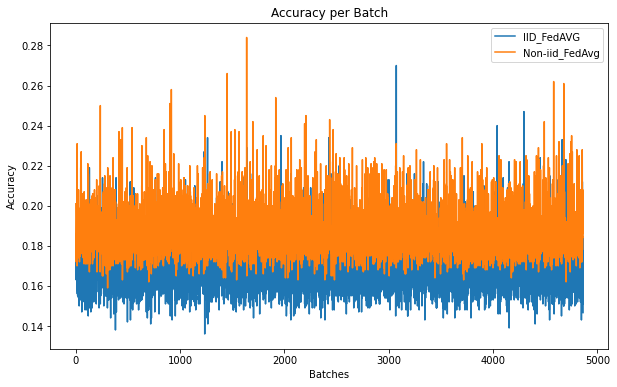

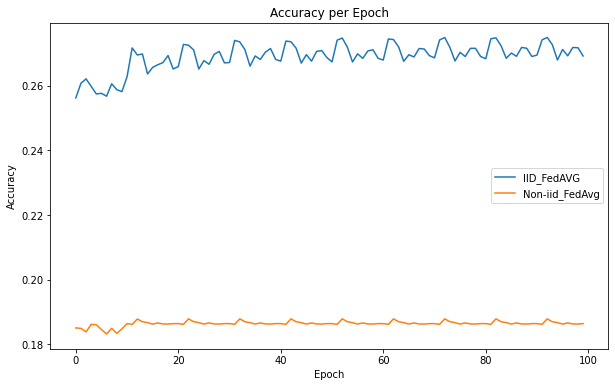

In [28]:
plt.figure(figsize=(10,6))
plt.plot(accs_fedavg_iid, label='IID_FedAVG')
plt.plot(accs_fedavg_noniid, label='Non-iid_FedAvg')
plt.title('Accuracy per Batch')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(cliets_acc_fedavg_iid, label='IID_FedAVG')
plt.plot(cliets_acc_fedavg_noniid, label='Non-iid_FedAvg')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

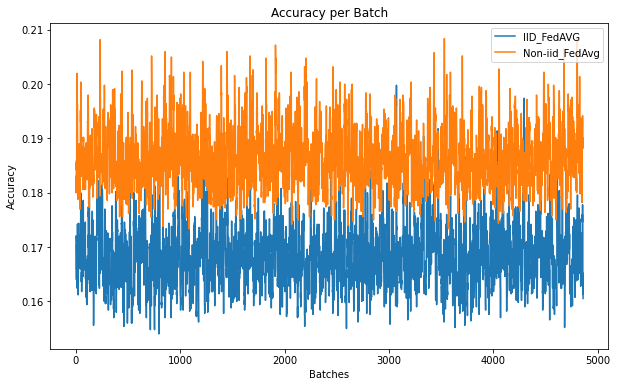

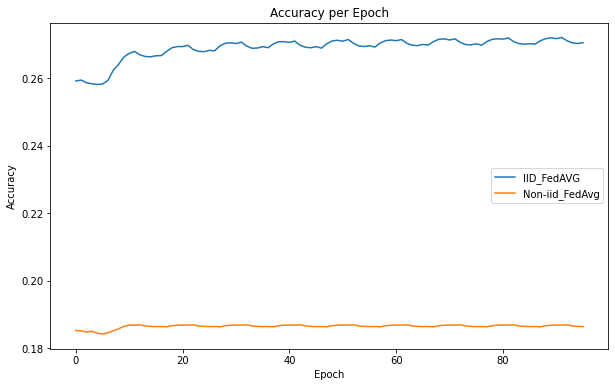

In [29]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(accs_fedavg_iid , np.ones(5)/5, mode='valid'), label='IID_FedAVG')
plt.plot(np.convolve(accs_fedavg_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedAvg')
plt.title('Accuracy per Batch')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(np.convolve(cliets_acc_fedavg_iid , np.ones(5)/5, mode='valid'), label='IID_FedAVG')
plt.plot(np.convolve(cliets_acc_fedavg_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedAvg')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**FedProx IID**

In [30]:
#Addition loss function to modify our loss during training 
def loss_function(net, w_t, p_loss, mu):
    w_dict = net.state_dict()
    loss2 = 0
    for l in w_dict.keys():
        loss2 += torch.norm(w_dict[l].float() - w_t[l].float(), p = 2)
    return p_loss + (mu /2) * loss2

In [31]:
#training is same as fedavg with regard to new loss function
def train_fedprox(model, dataloader, criterion, optimizer, mu, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_total = 0
    w_t = copy.deepcopy(model.state_dict())
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs, _ = model(inputs, None)
        loss = criterion(outputs.view(-1, outputs.size(2)), targets.view(-1))
        loss2 = loss_function(model, w_t, p_loss=loss, mu=mu)
        loss2.backward()
        optimizer.step()
        
        total_loss += loss2.item()
        total_correct += torch.sum(torch.argmax(outputs, dim=2) == targets).item()
        total_total += targets.numel()
    
    avg_loss = total_loss / len(dataloader)
    avg_acc = total_correct / total_total
    return avg_loss, avg_acc

In [32]:
def federated_prox(model, client_datasets, num_epochs, batch_size, lr, mu, device):
    global_weights = model.state_dict()
    criterion = nn.CrossEntropyLoss()
    losses = []
    accuracies = []
    for epoch in range(num_epochs):
        client_weights = []
        
        for client_text in client_texts:
            client_dataset = ShakespeareDataset(client_text, seq_length)
            client_dataloader = DataLoader(client_dataset, batch_size=batch_size, shuffle=True)
            client_model = ShakespeareLSTM(vocab_size, embedding_dim, hidden_dim).to(device)
            client_model.load_state_dict(global_weights)
            client_optimizer = optim.Adam(client_model.parameters(), lr=lr)
            avg_loss, avg_acc = train_fedprox(client_model, client_dataloader, criterion, client_optimizer, mu=mu, device=device)
            losses.append(avg_loss)
            accuracies.append(avg_acc)
            client_weights.append(client_model.state_dict())
        
        global_weights = average_weights(client_weights)
        model.load_state_dict(global_weights)
        
        print(f"Epoch {epoch+1}:")
        print(f"Training loss: {avg_loss:.4f}")
        print(f"Training accuracy: {avg_acc:.4f}")
    return losses, accuracies

In [33]:
def average_weights(weights):
    avg_weights = {}
    for name in weights[0]:
        avg_weights[name] = sum(w[name] for w in weights) / len(weights)
    return avg_weights

In [34]:
with open('data_preprocess.txt', 'r') as f:
    text = f.read()
if not text:
    text = "default text"
text = str(text)
chars = list(text)
n_clients = 10
client_texts = np.array_split(chars, n_clients)
for i, client_text in enumerate(client_texts):
    print(f"Client {i}: {len(client_text)}")

Client 0: 486431
Client 1: 486431
Client 2: 486431
Client 3: 486431
Client 4: 486431
Client 5: 486430
Client 6: 486430
Client 7: 486430
Client 8: 486430
Client 9: 486430


In [35]:
seq_length = 100
chars = sorted(list(set(text)))
vocab_size = len(chars)
embedding_dim = 64
hidden_dim = 256
num_epochs = 10
batch_size = 10
lr = 0.001
mu = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = ShakespeareDataset(text, seq_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = ShakespeareLSTM(vocab_size, embedding_dim, hidden_dim).to(device)
clients_loss_fedprox_iid, cliets_acc_fedprox_iid = federated_prox(model, client_texts, num_epochs, batch_size, lr, mu, device)

Epoch 1:
Training loss: 13.4160
Training accuracy: 0.2545
Epoch 2:
Training loss: 10.2163
Training accuracy: 0.2631
Epoch 3:
Training loss: 9.1936
Training accuracy: 0.2667
Epoch 4:
Training loss: 8.5959
Training accuracy: 0.2676
Epoch 5:
Training loss: 8.2833
Training accuracy: 0.2683
Epoch 6:
Training loss: 8.0992
Training accuracy: 0.2685
Epoch 7:
Training loss: 7.8194
Training accuracy: 0.2682
Epoch 8:
Training loss: 7.7958
Training accuracy: 0.2690
Epoch 9:
Training loss: 7.6399
Training accuracy: 0.2687
Epoch 10:
Training loss: 7.4811
Training accuracy: 0.2682


In [36]:
losses_fedprox_iid = []
accs_fedprox_iid = []
criterion = nn.CrossEntropyLoss()

for inputs, targets in train_dataloader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs, _ = model(inputs, None)
    loss = criterion(outputs.view(-1, outputs.size(2)), targets.view(-1))
    losses_fedprox_iid.append(loss.item())
    accs_fedprox_iid.append(torch.sum(torch.argmax(outputs, dim=2) == targets).item() / targets.numel())

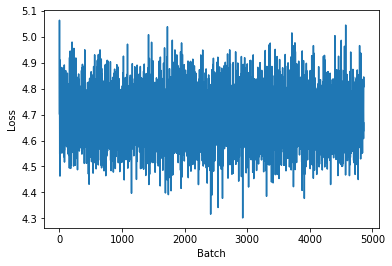

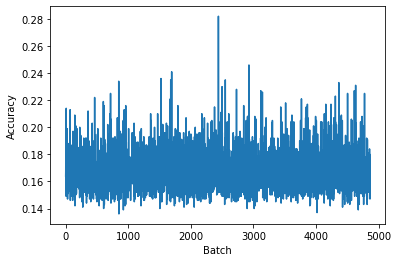

In [37]:
plt.plot(losses_fedprox_iid)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

plt.plot(accs_fedprox_iid)
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.show()

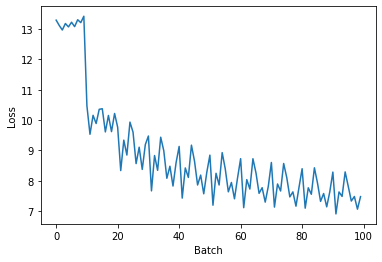

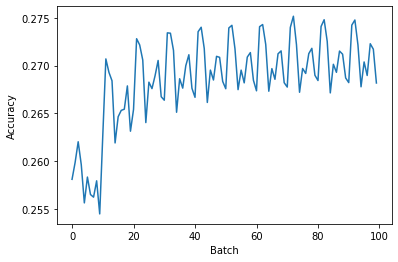

In [38]:
plt.plot(clients_loss_fedprox_iid)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

plt.plot(cliets_acc_fedprox_iid)
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.show()

**Non-iid FedProx**

In [39]:
import random
import math

def split_data(text, n_clients):
    # Compute indices for non-IID data distribution
    n_samples = len(text)
    client_indices = []
    for i in range(n_clients):
        start_idx = (i * n_samples) // n_clients
        end_idx = ((i + 1) * n_samples) // n_clients
        client_indices.append(np.arange(start_idx, end_idx))

    # Assign each set of indices to a client
    client_texts = []
    for indices in client_indices:
        client_text = ''.join([text[i] for i in indices])
        client_texts.append(client_text)

    return client_texts

with open('data_preprocess.txt', 'r') as f:
    text = f.read()
if not text:
    text = "default text"
text = str(text)
char_noniid = list(text)

num_clients = 10
# Define the non-IID distribution of documents per client
docs_per_client = [10, 15, 5, 20, 25, 10, 5, 15, 5, 10]
# Determine the total number of documents in the dataset
total_docs = len(char_noniid)
# Shuffle the dataset randomly to ensure that the distribution is not biased
random.shuffle(char_noniid)
# Calculate the number of documents to assign to each client
num_docs_per_client = []
for i in range(num_clients):
    num_docs = math.floor(docs_per_client[i] / sum(docs_per_client) * total_docs)
    num_docs_per_client.append(num_docs)
# Assign documents to each client
client_texts = []
start = 0
for i in range(num_clients):
    end = start + num_docs_per_client[i]
    client_texts.append(char_noniid[start:end])
    start = end

for i, client_text in enumerate(client_texts):
    print(f"Client {i}: {len(client_text)}")

Client 0: 405358
Client 1: 608038
Client 2: 202679
Client 3: 810717
Client 4: 1013396
Client 5: 405358
Client 6: 202679
Client 7: 608038
Client 8: 202679
Client 9: 405358


In [40]:
seq_length = 100
chars = sorted(list(set(text)))
vocab_size = len(chars)
embedding_dim = 64
hidden_dim = 256
num_epochs = 10
batch_size = 10
lr = 0.001
mu = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = ShakespeareDataset(text, seq_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = ShakespeareLSTM(vocab_size, embedding_dim, hidden_dim).to(device)
clients_loss_fedprox_noniid, cliets_acc_fedprox_noniid = federated_prox(model, client_texts, num_epochs, batch_size, lr, mu, device)

Epoch 1:
Training loss: 10.5827
Training accuracy: 0.1850
Epoch 2:
Training loss: 8.3414
Training accuracy: 0.1866
Epoch 3:
Training loss: 8.1122
Training accuracy: 0.1866
Epoch 4:
Training loss: 8.4304
Training accuracy: 0.1866
Epoch 5:
Training loss: 8.5033
Training accuracy: 0.1866
Epoch 6:
Training loss: 8.5779
Training accuracy: 0.1866
Epoch 7:
Training loss: 8.6202
Training accuracy: 0.1866
Epoch 8:
Training loss: 8.6417
Training accuracy: 0.1866
Epoch 9:
Training loss: 8.7845
Training accuracy: 0.1866
Epoch 10:
Training loss: 8.7915
Training accuracy: 0.1866


In [41]:
losses_fedprox_noniid = []
accs_fedprox_noniid = []
criterion = nn.CrossEntropyLoss()

for inputs, targets in train_dataloader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs, _ = model(inputs, None)
    loss = criterion(outputs.view(-1, outputs.size(2)), targets.view(-1))
    losses_fedprox_noniid.append(loss.item())
    accs_fedprox_noniid.append(torch.sum(torch.argmax(outputs, dim=2) == targets).item() / targets.numel())

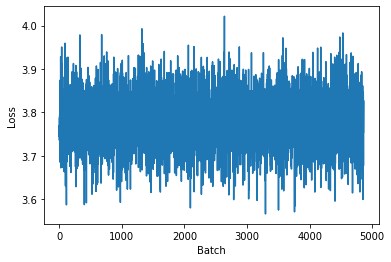

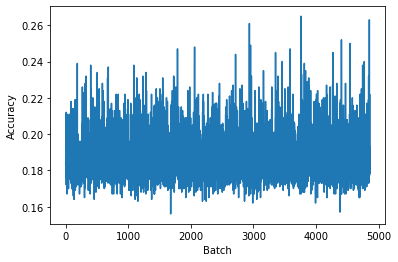

In [42]:
plt.plot(losses_fedprox_noniid)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

plt.plot(accs_fedprox_noniid)
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.show()

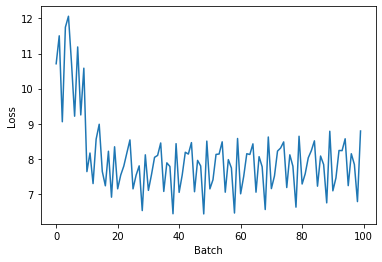

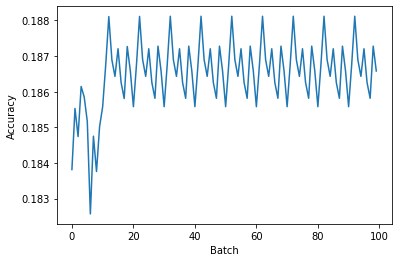

In [43]:
plt.plot(clients_loss_fedprox_noniid)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

plt.plot(cliets_acc_fedprox_noniid)
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.show()

**Compare IID and Non-IID distribution results in FedProx**

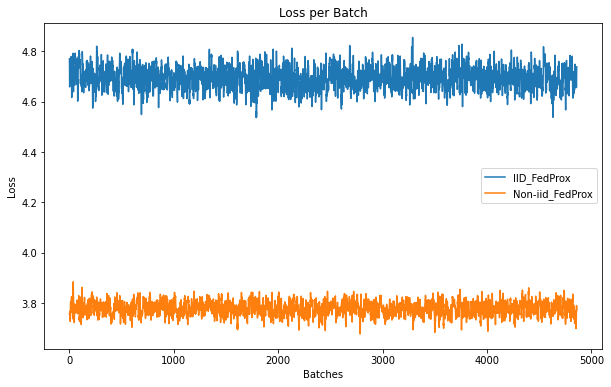

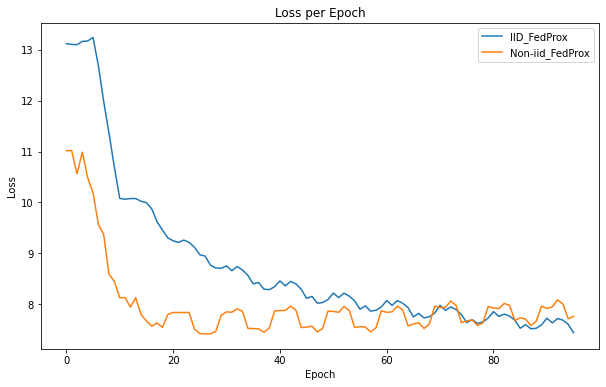

In [44]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(losses_fedprox_iid , np.ones(5)/5, mode='valid'), label='IID_FedProx')
plt.plot(np.convolve(losses_fedprox_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedProx')
plt.title('Loss per Batch')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(np.convolve(clients_loss_fedprox_iid , np.ones(5)/5, mode='valid'), label='IID_FedProx')
plt.plot(np.convolve(clients_loss_fedprox_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedProx')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

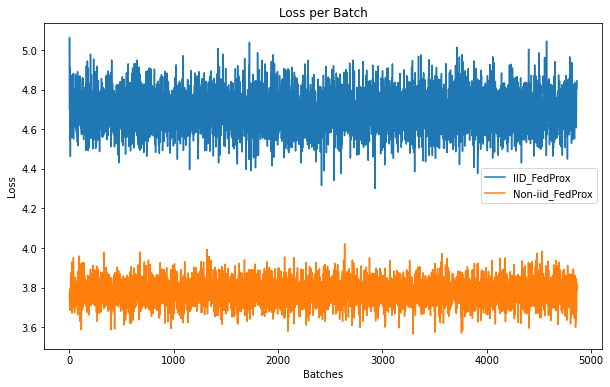

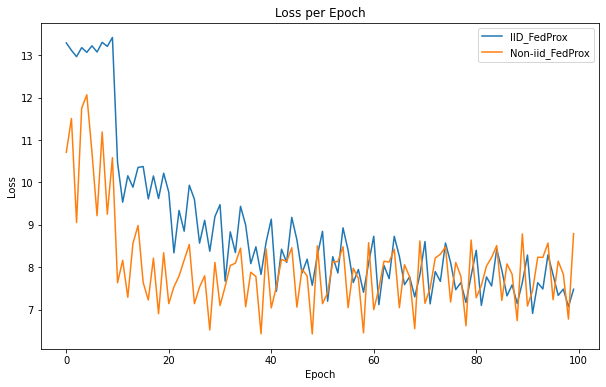

In [45]:
plt.figure(figsize=(10,6))
plt.plot(losses_fedprox_iid, label='IID_FedProx')
plt.plot(losses_fedprox_noniid, label='Non-iid_FedProx')
plt.title('Loss per Batch')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(clients_loss_fedprox_iid, label='IID_FedProx')
plt.plot(clients_loss_fedprox_noniid, label='Non-iid_FedProx')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

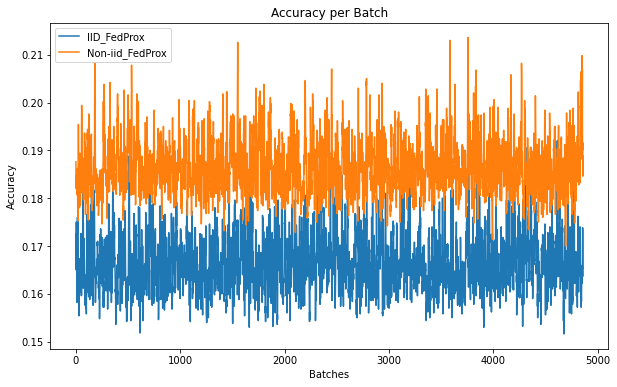

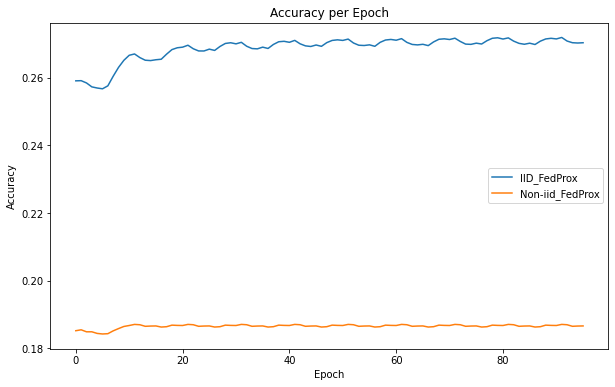

In [46]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(accs_fedprox_iid , np.ones(5)/5, mode='valid'), label='IID_FedProx')
plt.plot(np.convolve(accs_fedprox_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedProx')
plt.title('Accuracy per Batch')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(np.convolve(cliets_acc_fedprox_iid , np.ones(5)/5, mode='valid'), label='IID_FedProx')
plt.plot(np.convolve(cliets_acc_fedprox_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedProx')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

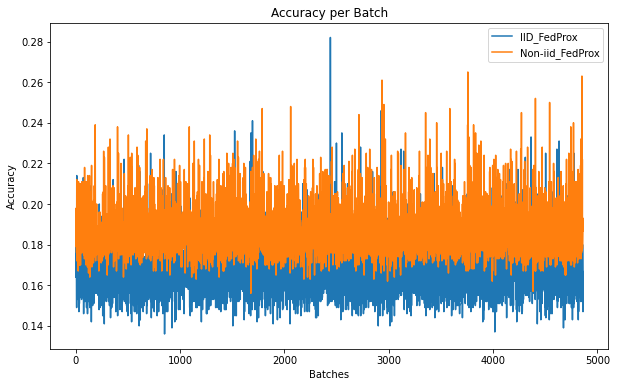

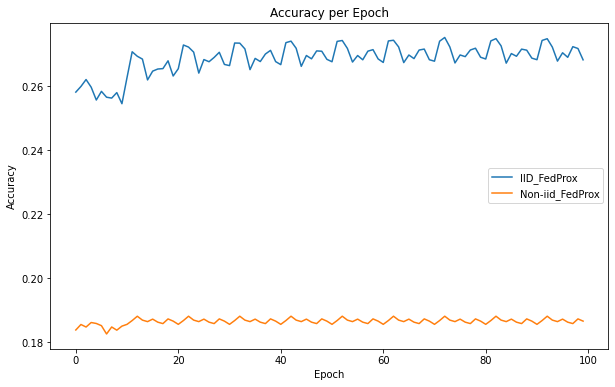

In [47]:
plt.figure(figsize=(10,6))
plt.plot(accs_fedprox_iid, label='IID_FedProx')
plt.plot(accs_fedprox_noniid, label='Non-iid_FedProx')
plt.title('Accuracy per Batch')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(cliets_acc_fedprox_iid, label='IID_FedProx')
plt.plot(cliets_acc_fedprox_noniid, label='Non-iid_FedProx')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Compare Fedprox and FedAVG**

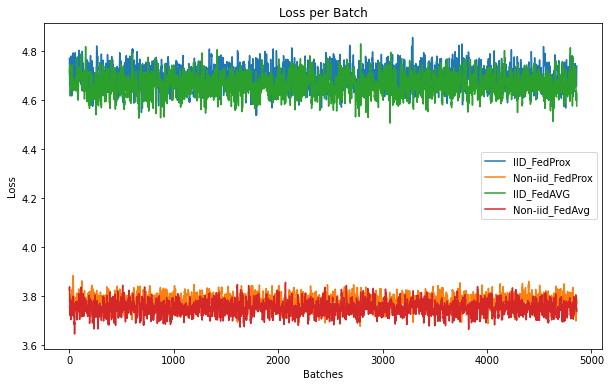

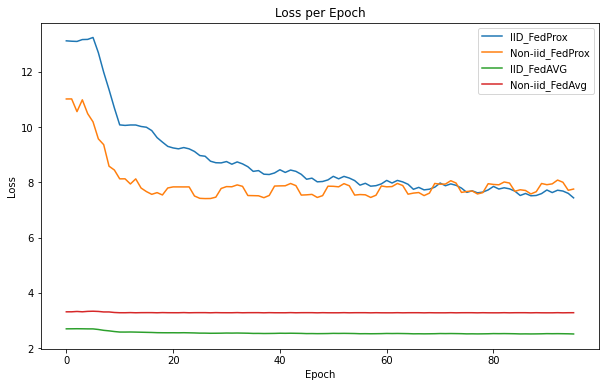

In [48]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(losses_fedprox_iid , np.ones(5)/5, mode='valid'), label='IID_FedProx')
plt.plot(np.convolve(losses_fedprox_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedProx')
plt.plot(np.convolve(losses_fedavg_iid , np.ones(5)/5, mode='valid'), label='IID_FedAVG')
plt.plot(np.convolve(losses_fedavg_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedAvg')
plt.title('Loss per Batch')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(np.convolve(clients_loss_fedprox_iid , np.ones(5)/5, mode='valid'), label='IID_FedProx')
plt.plot(np.convolve(clients_loss_fedprox_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedProx')
plt.plot(np.convolve(clients_loss_fedavg_iid , np.ones(5)/5, mode='valid'), label='IID_FedAVG')
plt.plot(np.convolve(clients_loss_fedavg_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedAvg')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

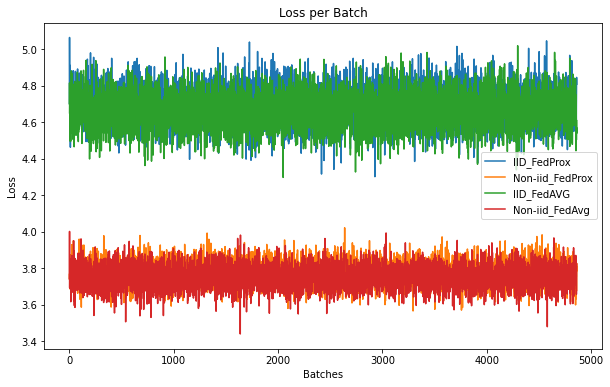

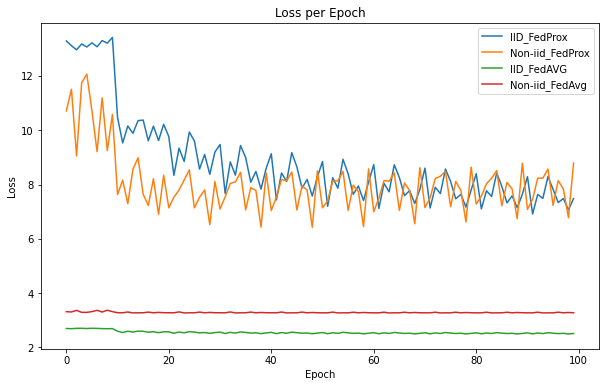

In [49]:
plt.figure(figsize=(10,6))
plt.plot(losses_fedprox_iid, label='IID_FedProx')
plt.plot(losses_fedprox_noniid, label='Non-iid_FedProx')
plt.plot(losses_fedavg_iid, label='IID_FedAVG')
plt.plot(losses_fedavg_noniid, label='Non-iid_FedAvg')
plt.title('Loss per Batch')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(clients_loss_fedprox_iid, label='IID_FedProx')
plt.plot(clients_loss_fedprox_noniid, label='Non-iid_FedProx')
plt.plot(clients_loss_fedavg_iid, label='IID_FedAVG')
plt.plot(clients_loss_fedavg_noniid, label='Non-iid_FedAvg')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

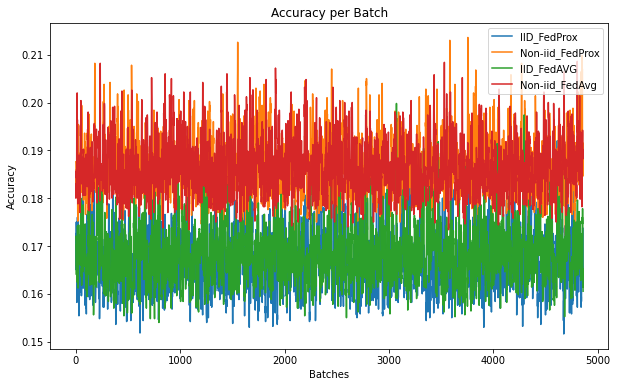

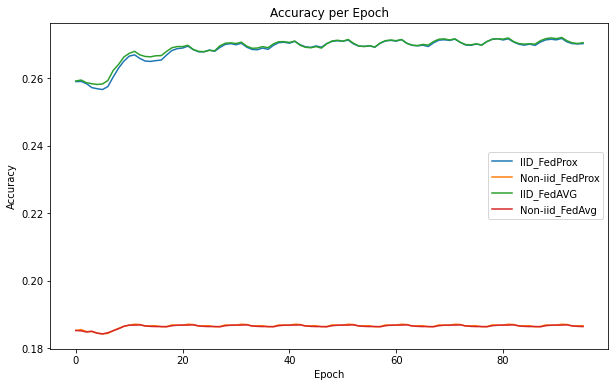

In [50]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(accs_fedprox_iid , np.ones(5)/5, mode='valid'), label='IID_FedProx')
plt.plot(np.convolve(accs_fedprox_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedProx')
plt.plot(np.convolve(accs_fedavg_iid , np.ones(5)/5, mode='valid'), label='IID_FedAVG')
plt.plot(np.convolve(accs_fedavg_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedAvg')
plt.title('Accuracy per Batch')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(np.convolve(cliets_acc_fedprox_iid , np.ones(5)/5, mode='valid'), label='IID_FedProx')
plt.plot(np.convolve(cliets_acc_fedprox_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedProx')
plt.plot(np.convolve(cliets_acc_fedavg_iid , np.ones(5)/5, mode='valid'), label='IID_FedAVG')
plt.plot(np.convolve(cliets_acc_fedavg_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedAvg')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

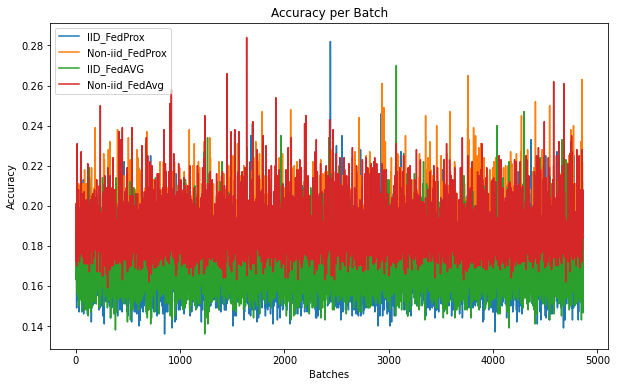

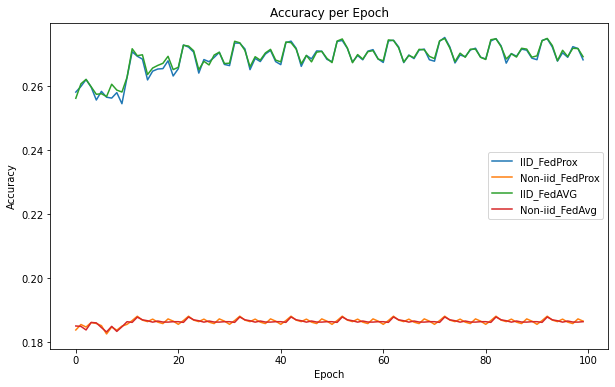

In [51]:
plt.figure(figsize=(10,6))
plt.plot(accs_fedprox_iid, label='IID_FedProx')
plt.plot(accs_fedprox_noniid, label='Non-iid_FedProx')
plt.plot(accs_fedavg_iid, label='IID_FedAVG')
plt.plot(accs_fedavg_noniid, label='Non-iid_FedAvg')
plt.title('Accuracy per Batch')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(cliets_acc_fedprox_iid, label='IID_FedProx')
plt.plot(cliets_acc_fedprox_noniid, label='Non-iid_FedProx')
plt.plot(cliets_acc_fedavg_iid, label='IID_FedAVG')
plt.plot(cliets_acc_fedavg_noniid, label='Non-iid_FedAvg')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**ADMM based Federated Learning**

In [52]:
class ShakespeareDataset(Dataset):
    def __init__(self, text, seq_length):
        self.seq_length = seq_length
        chars = sorted(list(set(text)))
        self.char_to_idx = {ch: i for i, ch in enumerate(chars)}
        self.idx_to_char = {i: ch for i, ch in enumerate(chars)}
        self.data = self._prepare_data(text)
    
    def _prepare_data(self, text):
        data = [self.char_to_idx[ch] for ch in text]
        return data
    
    def __getitem__(self, idx):
        start_idx = idx * self.seq_length
        end_idx = (idx + 1) * self.seq_length + 1
        input_seq = self.data[start_idx:end_idx-1]
        target_seq = self.data[start_idx+1:end_idx]
        return torch.LongTensor(input_seq), torch.LongTensor(target_seq)
    
    def __len__(self):
        return len(self.data) // self.seq_length

In [53]:
class ShakespeareLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(ShakespeareLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x, hidden):
        x = self.embedding(x)
        x, hidden = self.lstm(x, hidden)
        x = self.fc(x)
        return x, hidden

    def get_grads(self):
        return [p.grad for p in self.parameters() if p.grad is not None]

In [54]:
def train_admm_base(model, dataloader, criterion, optimizer1, optimizer2, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_total = 0
    
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        model.zero_grad()
        outputs, _ = model(inputs, None)
        loss = criterion(outputs.view(-1, outputs.size(2)), targets.view(-1))
        loss.backward()
        optimizer1.step()
        optimizer2.step()
        
        total_loss += loss.item()
        total_correct += torch.sum(torch.argmax(outputs, dim=2) == targets).item()
        total_total += targets.numel()
    
    avg_loss = total_loss / len(dataloader)
    avg_acc = total_correct / total_total
    return avg_loss, avg_acc

**LIADMM federated learning on iid distribution**

In [55]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class ShakespeareDataset(Dataset):
    def __init__(self, text, seq_length):
        self.seq_length = seq_length
        chars = sorted(list(set(text)))
        self.char_to_idx = {ch: i for i, ch in enumerate(chars)}
        self.idx_to_char = {i: ch for i, ch in enumerate(chars)}
        self.data = self._prepare_data(text)
    
    def _prepare_data(self, text):
        data = [self.char_to_idx[ch] for ch in text]
        return data
    
    def __getitem__(self, idx):
        start_idx = idx * self.seq_length
        end_idx = (idx + 1) * self.seq_length + 1
        input_seq = self.data[start_idx:end_idx-1]
        target_seq = self.data[start_idx+1:end_idx]
        return torch.LongTensor(input_seq), torch.LongTensor(target_seq)
    
    def __len__(self):
        return len(self.data) // self.seq_length

class ShakespeareLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(ShakespeareLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x, hidden):
        x = self.embedding(x)
        x, hidden = self.lstm(x, hidden)
        x = self.fc(x)
        return x, hidden

    def get_grads(self):
        return [p.grad for p in self.parameters() if p.grad is not None]

def train_admm_base(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_total = 0
    
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        model.zero_grad()
        outputs, _ = model(inputs, None)
        loss = criterion(outputs.view(-1, outputs.size(2)), targets.view(-1))
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_correct += torch.sum(torch.argmax(outputs, dim=2) == targets).item()
        total_total += targets.numel()
    
    avg_loss = total_loss / len(dataloader)
    avg_acc = total_correct / total_total
    return avg_loss, avg_acc

def train_fedlinearized(model, client_datasets, num_epochs, batch_size, lr, rho, mu, device):
    # Initialize global weights to the model's initial state
    global_weights = model.state_dict()
    # Initialize global loss to infinity
    global_loss = float("inf")
    # Define the loss function
    criterion = nn.CrossEntropyLoss()
    # Initialize lists for storing the losses and accuracies
    losses = []
    accuracies = []
    
    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        # Initialize lists to store the client weights and losses
        client_weights = []
        client_losses = []
        
        # Loop over each client dataset
        for client_text in client_texts:
            # Create a dataset and data loader for the current client
            client_dataset = ShakespeareDataset(client_text, seq_length)
            client_dataloader = DataLoader(client_dataset, batch_size=batch_size, shuffle=True)
            # Create a new model for the client and load the global weights
            client_model = ShakespeareLSTM(vocab_size, embedding_dim, hidden_dim).to(device)
            client_model.load_state_dict(global_weights)
            # Create an optimizer for the client model
            client_optimizer = optim.Adam(client_model.parameters(), lr=lr)
            # Train the client model using ADMM and store its weights and loss
            avg_loss, avg_acc = train_admm_base(client_model, client_dataloader, criterion, client_optimizer, device)
            client_weights.append(client_model.state_dict())
            client_losses.append(avg_loss)

        # Perform the ADMM step to update the global weights
        for name, param in model.named_parameters():
            # Ignore biases
            if 'bias' in name:
                continue
            # Convert the relevant variables to tensors and move them to the specified device
            rho_tensor = torch.FloatTensor([rho]).to(device)
            mu_tensor = torch.FloatTensor([mu]).to(device)
            client_weights_tensors = [torch.FloatTensor(list(w[name].flatten())).to(device) for w in client_weights]
            # Compute the mean of the client weights and reshape them to match the shape of the current parameter
            alpha_tensor = torch.mean(torch.stack(client_weights_tensors), dim=0)
            alpha_tensor = alpha_tensor.view(param.shape)
            z_tensor = param.data
            u_tensor = torch.zeros_like(alpha_tensor)

            # Perform 5 iterations of the ADMM algorithm
            for i in range(5):
                # Update z
                temp = alpha_tensor + u_tensor
                param.data = (rho_tensor / (mu_tensor + rho_tensor)) * temp + (mu_tensor / (mu_tensor + rho_tensor)) * z_tensor
                # Update u
                u_tensor = u_tensor + alpha_tensor - param.data

        # Update the global weights
        global_weights = model.state_dict()
        # Update the learning rate
        lr = lr * 0.99

        # Compute the global loss and accuracy
        model.load_state_dict(global_weights)
        global_loss = 0.0
        total_correct = 0
        total_total = 0
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs, _ = model(inputs, None)
            loss = criterion(outputs.view(-1, outputs.size(2)), targets.view(-1))
            global_loss += loss.item()
            total_correct += torch.sum(torch.argmax(outputs, dim=2) == targets).item()
            total_total += targets.numel()

        # Compute the average loss and accuracy and store them in the lists

        avg_loss = global_loss / len(train_dataloader)
        avg_acc = total_correct / total_total
        losses.append(avg_loss)
        accuracies.append(avg_acc)

        print(f"Epoch {epoch+1}:")
        print(f"Training loss: {avg_loss:.4f}")
        print(f"Training accuracy: {avg_acc:.4f}")
    return losses, accuracies

In [56]:
def average_weights(weights):
    avg_weights = {}
    for name in weights[0]:
        avg_weights[name] = sum(w[name] for w in weights) / len(weights)
    return avg_weights

In [57]:
with open('data_preprocess.txt', 'r') as f:
    text = f.read()
if not text:
    text = "default text"
text = str(text)
chars = list(text)

In [58]:
n_clients = 10
client_texts = np.array_split(chars, n_clients)

In [59]:
for i, client_text in enumerate(client_texts):
    print(f"Client {i}: {len(client_text)}")

Client 0: 486431
Client 1: 486431
Client 2: 486431
Client 3: 486431
Client 4: 486431
Client 5: 486430
Client 6: 486430
Client 7: 486430
Client 8: 486430
Client 9: 486430


In [60]:
seq_length = 100
chars = sorted(list(set(text)))
vocab_size = len(chars)
embedding_dim = 64
hidden_dim = 256
num_epochs = 10
batch_size = 10
lr = 0.001
rho = 0.1
mu = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = ShakespeareDataset(text, seq_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = ShakespeareLSTM(vocab_size, embedding_dim, hidden_dim).to(device)
clients_loss_liadmm_iid, cliets_acc_liadmm_iid = train_fedlinearized(model, client_texts, num_epochs, batch_size, lr, rho, mu, device)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Epoch 1:
Training loss: 4.3653
Training accuracy: 0.1385
Epoch 2:
Training loss: 4.2927
Training accuracy: 0.1738
Epoch 3:
Training loss: 4.1932
Training accuracy: 0.1783
Epoch 4:
Training loss: 4.0860
Training accuracy: 0.1792
Epoch 5:
Training loss: 3.9935
Training accuracy: 0.1795
Epoch 6:
Training loss: 3.9293
Training accuracy: 0.1805
Epoch 7:
Training loss: 3.8956
Training accuracy: 0.1809
Epoch 8:
Training loss: 3.8857
Training accuracy: 0.1810
Epoch 9:
Training loss: 3.8936
Training accuracy: 0.1809
Epoch 10:
Training loss: 3.9152
Training accuracy: 0.1809


In [61]:
losses_liadmm_iid = []
accs_liadmm_iid = []
criterion = nn.CrossEntropyLoss()

for inputs, targets in train_dataloader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs, _ = model(inputs, None)
    loss = criterion(outputs.view(-1, outputs.size(2)), targets.view(-1))
    losses_liadmm_iid.append(loss.item())
    accs_liadmm_iid.append(torch.sum(torch.argmax(outputs, dim=2) == targets).item() / targets.numel())

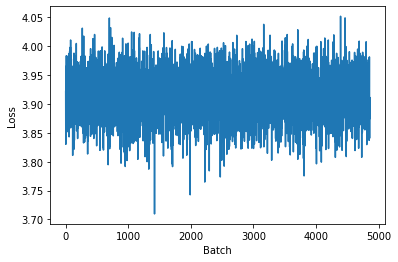

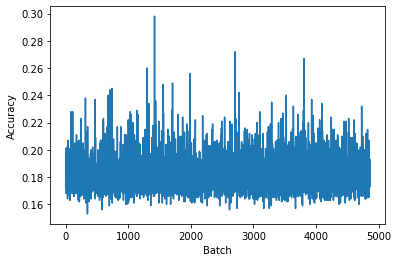

In [62]:
plt.plot(losses_liadmm_iid)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

plt.plot(accs_liadmm_iid)
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.show()

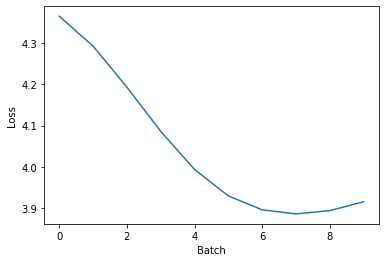

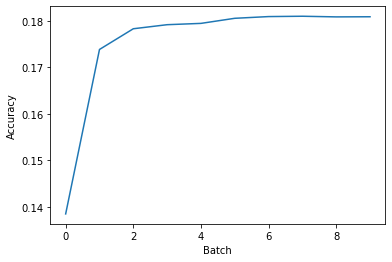

In [63]:
plt.plot(clients_loss_liadmm_iid)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

plt.plot(cliets_acc_liadmm_iid)
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.show()

**LIADMM Federated learnin on non-iid distribution**

In [64]:
def split_data(text, n_clients):
    # Compute indices for non-IID data distribution
    n_samples = len(text)
    client_indices = []
    for i in range(n_clients):
        start_idx = (i * n_samples) // n_clients
        end_idx = ((i + 1) * n_samples) // n_clients
        client_indices.append(np.arange(start_idx, end_idx))

    # Assign each set of indices to a client
    client_texts = []
    for indices in client_indices:
        client_text = ''.join([text[i] for i in indices])
        client_texts.append(client_text)

    return client_texts

In [65]:
import random
import math


with open('data_preprocess.txt', 'r') as f:
    text = f.read()
if not text:
    text = "default text"
text = str(text)
char_noniid = list(text)

num_clients = 10
# Define the non-IID distribution of documents per client
docs_per_client = [10, 15, 5, 20, 25, 10, 5, 15, 5, 10]
# Determine the total number of documents in the dataset
total_docs = len(char_noniid)
# Shuffle the dataset randomly to ensure that the distribution is not biased
random.shuffle(char_noniid)
# Calculate the number of documents to assign to each client
num_docs_per_client = []
for i in range(num_clients):
    num_docs = math.floor(docs_per_client[i] / sum(docs_per_client) * total_docs)
    num_docs_per_client.append(num_docs)
# Assign documents to each client
client_texts = []
start = 0
for i in range(num_clients):
    end = start + num_docs_per_client[i]
    client_texts.append(char_noniid[start:end])
    start = end

In [66]:
for i, client_text in enumerate(client_texts):
    print(f"Client {i}: {len(client_text)}")

Client 0: 405358
Client 1: 608038
Client 2: 202679
Client 3: 810717
Client 4: 1013396
Client 5: 405358
Client 6: 202679
Client 7: 608038
Client 8: 202679
Client 9: 405358


In [67]:
seq_length = 100
chars = sorted(list(set(text)))
vocab_size = len(chars)
embedding_dim = 64
hidden_dim = 256
num_epochs = 10
batch_size = 10
lr = 0.001
rho = 0.1
mu = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = ShakespeareDataset(text, seq_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = ShakespeareLSTM(vocab_size, embedding_dim, hidden_dim).to(device)
clients_loss_liadmm_noniid, cliets_acc_liadmm_noniid = train_fedlinearized(model, client_texts, num_epochs, batch_size, lr, rho, mu, device)

Epoch 1:
Training loss: 4.3747
Training accuracy: 0.0919
Epoch 2:
Training loss: 4.2980
Training accuracy: 0.1738
Epoch 3:
Training loss: 4.1850
Training accuracy: 0.1818
Epoch 4:
Training loss: 4.0563
Training accuracy: 0.1848
Epoch 5:
Training loss: 3.9477
Training accuracy: 0.1852
Epoch 6:
Training loss: 3.8736
Training accuracy: 0.1853
Epoch 7:
Training loss: 3.8279
Training accuracy: 0.1854
Epoch 8:
Training loss: 3.8008
Training accuracy: 0.1855
Epoch 9:
Training loss: 3.7849
Training accuracy: 0.1856
Epoch 10:
Training loss: 3.7758
Training accuracy: 0.1856


In [68]:
losses_liadmm_noniid = []
accs_liadmm_noniid = []
criterion = nn.CrossEntropyLoss()

for inputs, targets in train_dataloader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs, _ = model(inputs, None)
    loss = criterion(outputs.view(-1, outputs.size(2)), targets.view(-1))
    losses_liadmm_noniid.append(loss.item())
    accs_liadmm_noniid.append(torch.sum(torch.argmax(outputs, dim=2) == targets).item() / targets.numel())

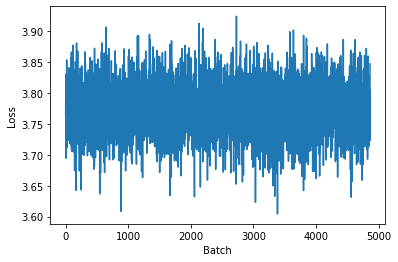

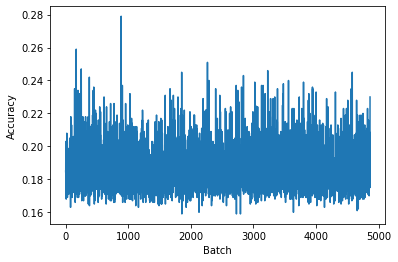

In [69]:
plt.plot(losses_liadmm_noniid)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

plt.plot(accs_liadmm_noniid)
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.show()

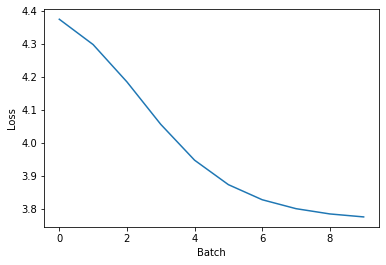

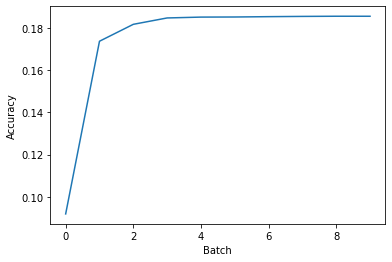

In [70]:
plt.plot(clients_loss_liadmm_noniid)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

plt.plot(cliets_acc_liadmm_noniid)
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.show()

**Compare IID and Non-IID distribution results in LiAdmm**

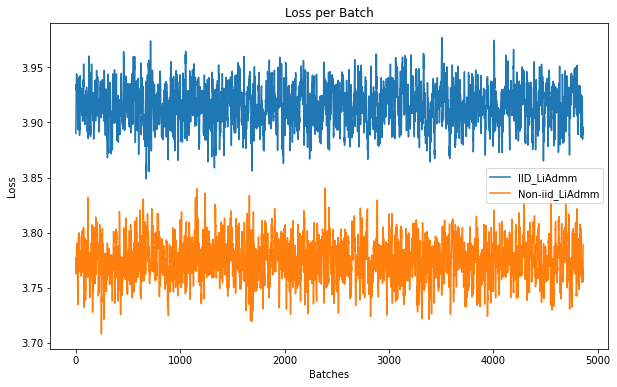

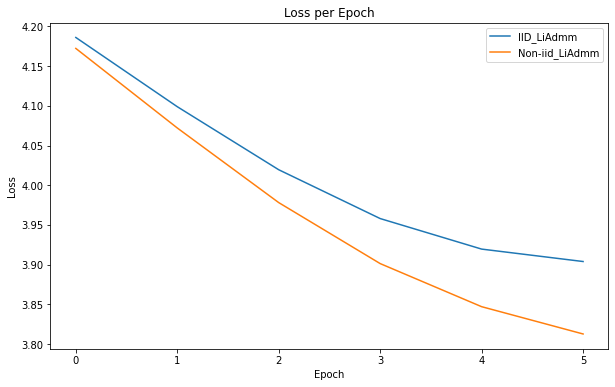

In [71]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(losses_liadmm_iid , np.ones(5)/5, mode='valid'), label='IID_LiAdmm')
plt.plot(np.convolve(losses_liadmm_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_LiAdmm')
plt.title('Loss per Batch')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(np.convolve(clients_loss_liadmm_iid , np.ones(5)/5, mode='valid'), label='IID_LiAdmm')
plt.plot(np.convolve(clients_loss_liadmm_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_LiAdmm')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

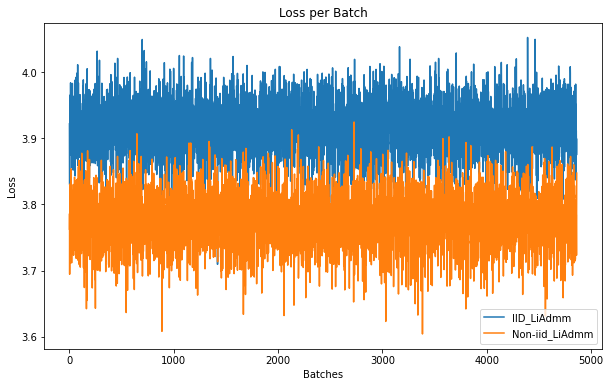

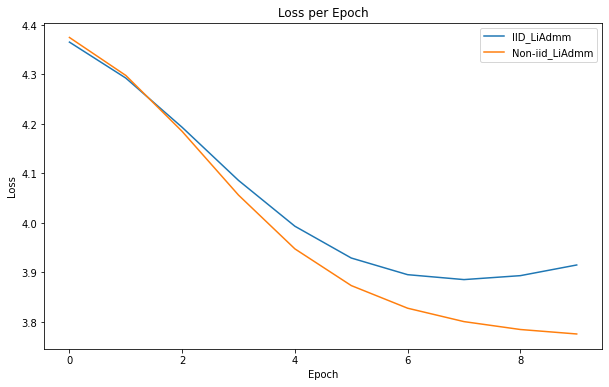

In [72]:
plt.figure(figsize=(10,6))
plt.plot(losses_liadmm_iid, label='IID_LiAdmm')
plt.plot(losses_liadmm_noniid, label='Non-iid_LiAdmm')
plt.title('Loss per Batch')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(clients_loss_liadmm_iid, label='IID_LiAdmm')
plt.plot(clients_loss_liadmm_noniid, label='Non-iid_LiAdmm')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

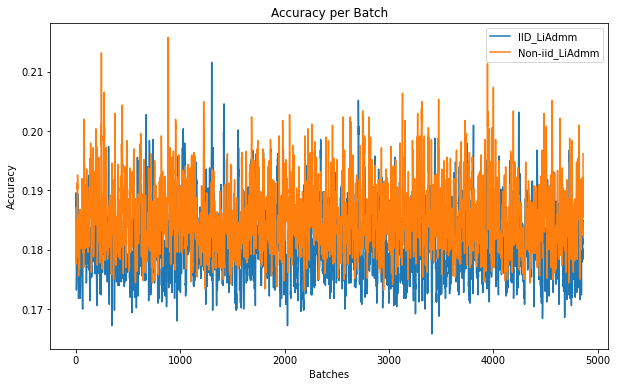

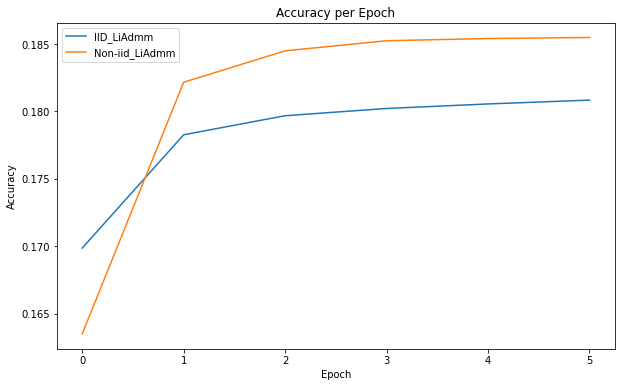

In [73]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(accs_liadmm_iid , np.ones(5)/5, mode='valid'), label='IID_LiAdmm')
plt.plot(np.convolve(accs_liadmm_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_LiAdmm')
plt.title('Accuracy per Batch')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(np.convolve(cliets_acc_liadmm_iid , np.ones(5)/5, mode='valid'), label='IID_LiAdmm')
plt.plot(np.convolve(cliets_acc_liadmm_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_LiAdmm')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

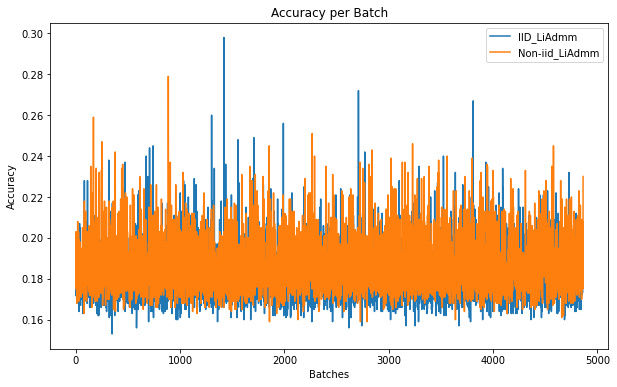

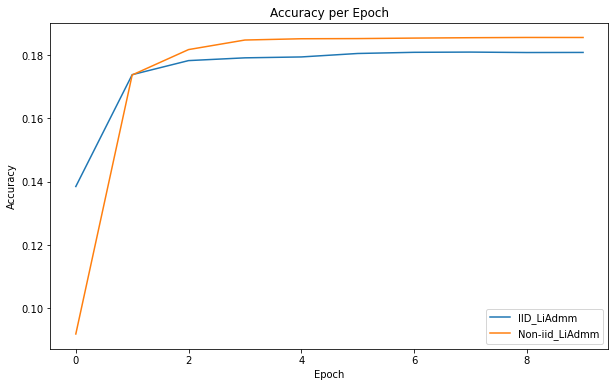

In [74]:
plt.figure(figsize=(10,6))
plt.plot(accs_liadmm_iid, label='IID_LiAdmm')
plt.plot(accs_liadmm_noniid, label='Non-iid_LiAdmm')
plt.title('Accuracy per Batch')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(cliets_acc_liadmm_iid, label='IID_LiAdmm')
plt.plot(cliets_acc_liadmm_noniid, label='Non-iid_LiAdmm')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**FedADMM on iid distribution**

In [75]:
class FedAdmm:
    def __init__(self, rho):
        self.rho = rho  # initialize the hyperparameter rho
        
    def step(self, model, u, z, client_weights, global_weights, lr):
        # beta is the step size
        beta = 1 / self.rho 
        
        # iterate through all the named parameters of the model
        for name, param in model.named_parameters():
            # extract the weights of all the clients for this parameter
            local_params = [w[name] for w in client_weights]
            
            # update the z value for this parameter using ADMM
            z[name] = (beta * global_weights[name] + sum(local_params) + u[name]).clamp(-1, 1)
            
            # update the global weights with a weighted sum of the current and the new value of z
            global_weights[name] = (lr * z[name] + (1-lr) * global_weights[name]).clamp(-1, 1)
            
            # update the u value for this parameter
            u[name] = u[name] + beta * (global_weights[name] - z[name])

def train_fedadmm(model, dataloader, criterion, optimizer, device, fedadmm, u, z, rho, lr, global_weights):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_total = 0
    
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        model.zero_grad()
        outputs, _ = model(inputs, None)
        loss = criterion(outputs.view(-1, outputs.size(2)), targets.view(-1))
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_correct += torch.sum(torch.argmax(outputs, dim=2) == targets).item()
        total_total += targets.numel()
    
    avg_loss = total_loss / len(dataloader)
    avg_acc = total_correct / total_total
    
    client_weights = [model.state_dict() for _ in range(len(dataloader))]
    fedadmm.step(model, u, z, client_weights, global_weights, lr)
    
    return avg_loss, avg_acc

def federated_fedadmm(model, client_datasets, num_epochs, batch_size, lr, rho, device):
    global_weights = model.state_dict()
    criterion = nn.CrossEntropyLoss()
    losses = []
    accuracies = []
    fedadmm = FedAdmm(rho)
    u = {name: torch.zeros_like(param) for name, param in global_weights.items()}
    z = {name: torch.zeros_like(param) for name, param in global_weights.items()}
    
    for epoch in range(num_epochs):
        for i, client_text in enumerate(client_texts):
            client_dataset = ShakespeareDataset(client_text, seq_length)
            client_dataloader = DataLoader(client_dataset, batch_size=batch_size, shuffle=True)
            client_model = ShakespeareLSTM(vocab_size, embedding_dim, hidden_dim).to(device)
            client_model.load_state_dict(global_weights)
            client_optimizer = optim.Adam(client_model.parameters(), lr=lr)
            avg_loss, avg_acc = train_fedadmm(client_model, client_dataloader, criterion, client_optimizer, device, fedadmm, u, z, rho, lr, global_weights)
            losses.append(avg_loss)
            accuracies.append(avg_acc)
            global_weights = client_model.state_dict()
        
        print(f"Epoch {epoch+1}:")
        print(f"Training loss: {avg_loss:.4f}")
        print(f"Training accuracy: {avg_acc:.4f}")
    return losses, accuracies


In [76]:
def average_weights(weights):
    avg_weights = {}
    for name in weights[0]:
        avg_weights[name] = sum(w[name] for w in weights) / len(weights)
    return avg_weights

In [77]:
with open('data_preprocess.txt', 'r') as f:
    text = f.read()
if not text:
    text = "default text"
text = str(text)
chars = list(text)

In [78]:
n_clients = 10
client_texts = np.array_split(chars, n_clients)

In [79]:
for i, client_text in enumerate(client_texts):
    print(f"Client {i}: {len(client_text)}")

Client 0: 486431
Client 1: 486431
Client 2: 486431
Client 3: 486431
Client 4: 486431
Client 5: 486430
Client 6: 486430
Client 7: 486430
Client 8: 486430
Client 9: 486430


In [80]:
seq_length = 100
chars = sorted(list(set(text)))
vocab_size = len(chars)
embedding_dim = 64
hidden_dim = 256
num_epochs = 10
batch_size = 10
lr = 0.001
rho = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = ShakespeareDataset(text, seq_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = ShakespeareLSTM(vocab_size, embedding_dim, hidden_dim).to(device)
clients_loss_fedadmm_iid, cliets_acc_fedadmm_iid = federated_fedadmm(model, client_texts, num_epochs, batch_size, lr, rho, device)

Epoch 1:
Training loss: 2.5651
Training accuracy: 0.2665
Epoch 2:
Training loss: 2.5661
Training accuracy: 0.2662
Epoch 3:
Training loss: 2.5655
Training accuracy: 0.2659
Epoch 4:
Training loss: 2.5638
Training accuracy: 0.2661
Epoch 5:
Training loss: 2.5634
Training accuracy: 0.2659
Epoch 6:
Training loss: 2.5612
Training accuracy: 0.2659
Epoch 7:
Training loss: 2.5625
Training accuracy: 0.2659
Epoch 8:
Training loss: 2.5596
Training accuracy: 0.2659
Epoch 9:
Training loss: 2.5593
Training accuracy: 0.2661
Epoch 10:
Training loss: 2.5580
Training accuracy: 0.2659


In [81]:
losses_fedadmm_iid = []
accs_fedadmm_iid = []
criterion = nn.CrossEntropyLoss()

for inputs, targets in train_dataloader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs, _ = model(inputs, None)
    loss = criterion(outputs.view(-1, outputs.size(2)), targets.view(-1))
    losses_fedadmm_iid.append(loss.item())
    accs_fedadmm_iid.append(torch.sum(torch.argmax(outputs, dim=2) == targets).item() / targets.numel())

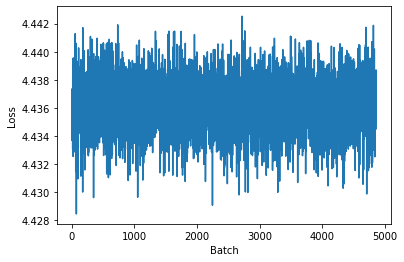

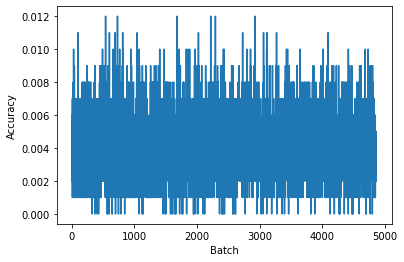

In [82]:
plt.plot(losses_fedadmm_iid)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

plt.plot(accs_fedadmm_iid)
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.show()

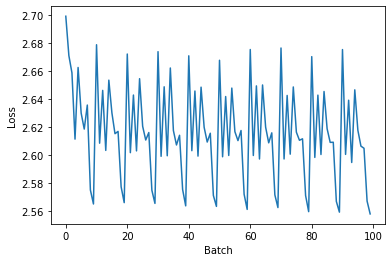

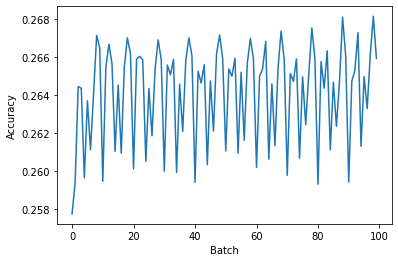

In [83]:
plt.plot(clients_loss_fedadmm_iid)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

plt.plot(cliets_acc_fedadmm_iid)
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.show()

**FedAdmm on non-iid distribution**

In [84]:
def split_data(text, n_clients):
    # Compute indices for non-IID data distribution
    n_samples = len(text)
    client_indices = []
    for i in range(n_clients):
        start_idx = (i * n_samples) // n_clients
        end_idx = ((i + 1) * n_samples) // n_clients
        client_indices.append(np.arange(start_idx, end_idx))

    # Assign each set of indices to a client
    client_texts = []
    for indices in client_indices:
        client_text = ''.join([text[i] for i in indices])
        client_texts.append(client_text)

    return client_texts

In [85]:
import random
import math


with open('data_preprocess.txt', 'r') as f:
    text = f.read()
if not text:
    text = "default text"
text = str(text)
char_noniid = list(text)

num_clients = 10
# Define the non-IID distribution of documents per client
docs_per_client = [10, 15, 5, 20, 25, 10, 5, 15, 5, 10]
# Determine the total number of documents in the dataset
total_docs = len(char_noniid)
# Shuffle the dataset randomly to ensure that the distribution is not biased
random.shuffle(char_noniid)
# Calculate the number of documents to assign to each client
num_docs_per_client = []
for i in range(num_clients):
    num_docs = math.floor(docs_per_client[i] / sum(docs_per_client) * total_docs)
    num_docs_per_client.append(num_docs)
# Assign documents to each client
client_texts = []
start = 0
for i in range(num_clients):
    end = start + num_docs_per_client[i]
    client_texts.append(char_noniid[start:end])
    start = end

In [86]:
for i, client_text in enumerate(client_texts):
    print(f"Client {i}: {len(client_text)}")

Client 0: 405358
Client 1: 608038
Client 2: 202679
Client 3: 810717
Client 4: 1013396
Client 5: 405358
Client 6: 202679
Client 7: 608038
Client 8: 202679
Client 9: 405358


In [87]:
seq_length = 100
chars = sorted(list(set(text)))
vocab_size = len(chars)
embedding_dim = 64
hidden_dim = 256
num_epochs = 10
batch_size = 10
lr = 0.001
rho = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = ShakespeareDataset(text, seq_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = ShakespeareLSTM(vocab_size, embedding_dim, hidden_dim).to(device)
clients_loss_fedadmm_noniid, cliets_acc_fedadmm_noniid = federated_fedadmm(model, client_texts, num_epochs, batch_size, lr, rho, device)

Epoch 1:
Training loss: 3.3274
Training accuracy: 0.1857
Epoch 2:
Training loss: 3.3321
Training accuracy: 0.1858
Epoch 3:
Training loss: 3.3268
Training accuracy: 0.1858
Epoch 4:
Training loss: 3.3275
Training accuracy: 0.1858
Epoch 5:
Training loss: 3.3205
Training accuracy: 0.1858
Epoch 6:
Training loss: 3.3184
Training accuracy: 0.1857
Epoch 7:
Training loss: 3.3133
Training accuracy: 0.1858
Epoch 8:
Training loss: 3.3202
Training accuracy: 0.1858
Epoch 9:
Training loss: 3.3158
Training accuracy: 0.1857
Epoch 10:
Training loss: 3.3204
Training accuracy: 0.1858


In [88]:
losses_fedadmm_noniid = []
accs_fedadmm_noniid = []
criterion = nn.CrossEntropyLoss()

for inputs, targets in train_dataloader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs, _ = model(inputs, None)
    loss = criterion(outputs.view(-1, outputs.size(2)), targets.view(-1))
    losses_fedadmm_noniid.append(loss.item())
    accs_fedadmm_noniid.append(torch.sum(torch.argmax(outputs, dim=2) == targets).item() / targets.numel())

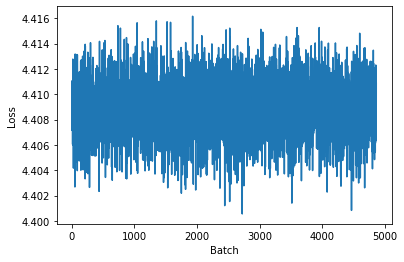

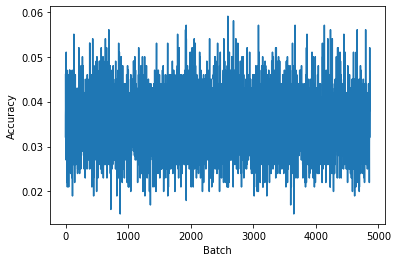

In [89]:
plt.plot(losses_fedadmm_noniid)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

plt.plot(accs_fedadmm_noniid)
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.show()

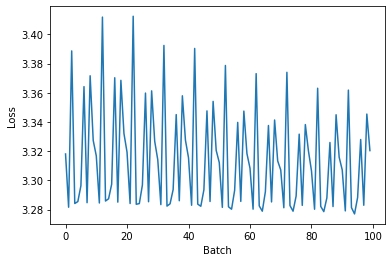

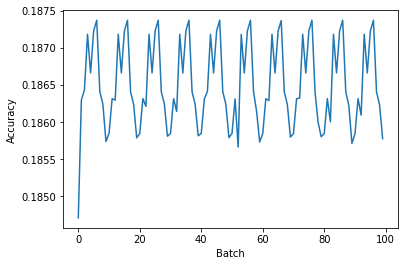

In [90]:
plt.plot(clients_loss_fedadmm_noniid)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

plt.plot(cliets_acc_fedadmm_noniid)
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.show()

**Compare IID and Non-IID distribution results in FedAdmm**

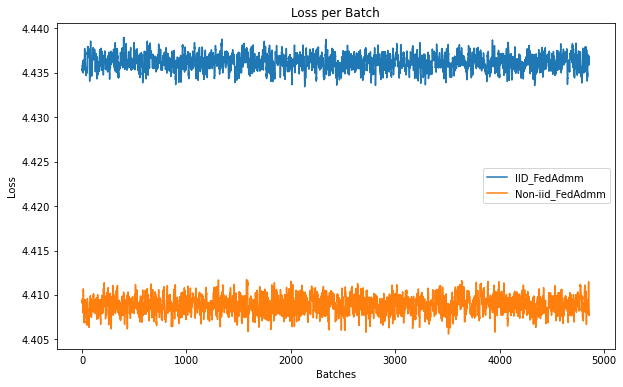

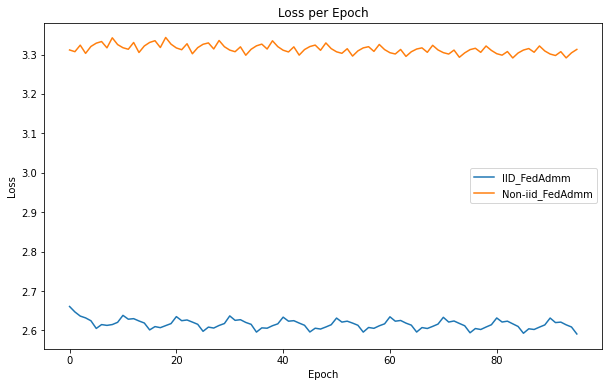

In [91]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(losses_fedadmm_iid , np.ones(5)/5, mode='valid'), label='IID_FedAdmm')
plt.plot(np.convolve(losses_fedadmm_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedAdmm')
plt.title('Loss per Batch')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(np.convolve(clients_loss_fedadmm_iid , np.ones(5)/5, mode='valid'), label='IID_FedAdmm')
plt.plot(np.convolve(clients_loss_fedadmm_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedAdmm')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

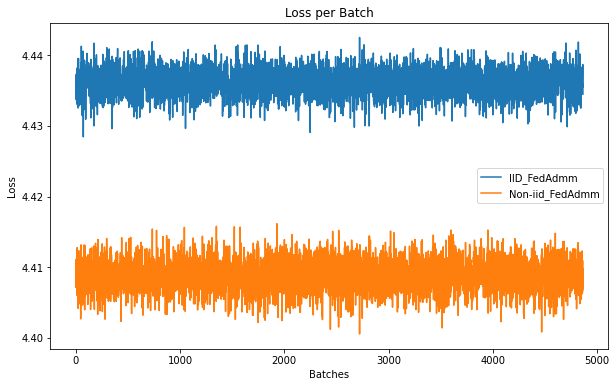

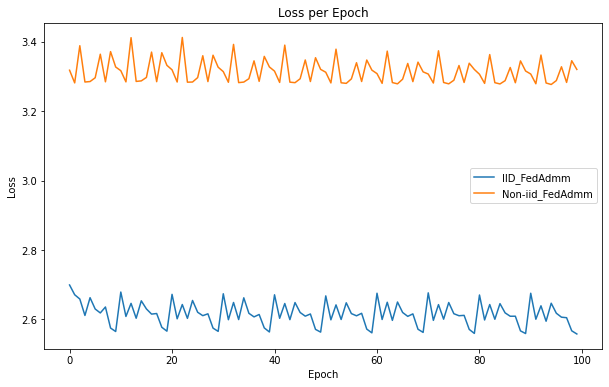

In [92]:
plt.figure(figsize=(10,6))
plt.plot(losses_fedadmm_iid, label='IID_FedAdmm')
plt.plot(losses_fedadmm_noniid, label='Non-iid_FedAdmm')
plt.title('Loss per Batch')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(clients_loss_fedadmm_iid, label='IID_FedAdmm')
plt.plot(clients_loss_fedadmm_noniid, label='Non-iid_FedAdmm')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

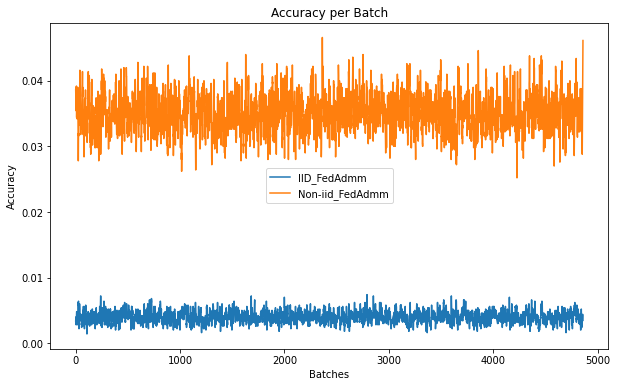

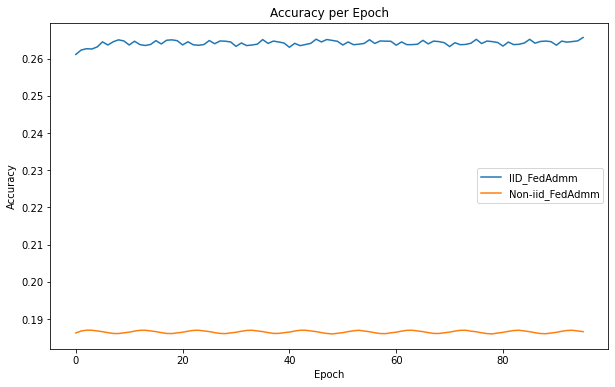

In [93]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(accs_fedadmm_iid , np.ones(5)/5, mode='valid'), label='IID_FedAdmm')
plt.plot(np.convolve(accs_fedadmm_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedAdmm')
plt.title('Accuracy per Batch')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(np.convolve(cliets_acc_fedadmm_iid , np.ones(5)/5, mode='valid'), label='IID_FedAdmm')
plt.plot(np.convolve(cliets_acc_fedadmm_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedAdmm')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

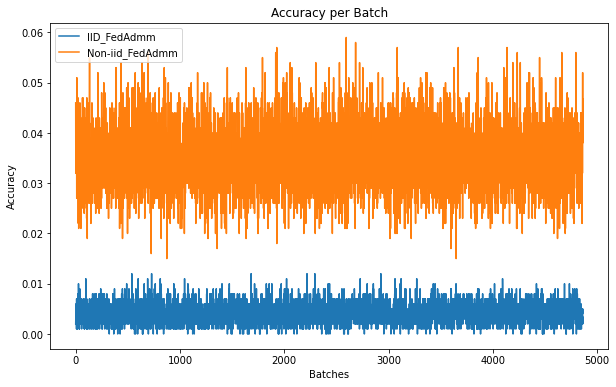

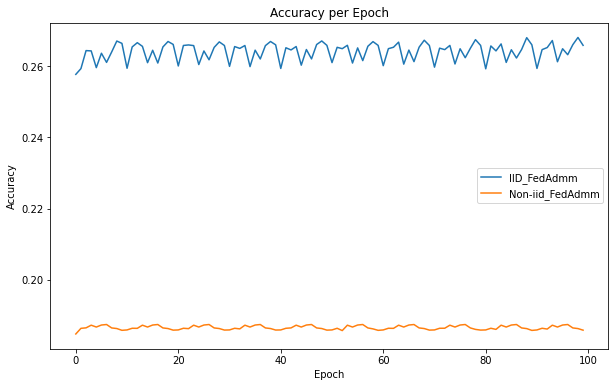

In [94]:
plt.figure(figsize=(10,6))
plt.plot(accs_fedadmm_iid, label='IID_FedAdmm')
plt.plot(accs_fedadmm_noniid, label='Non-iid_FedAdmm')
plt.title('Accuracy per Batch')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(cliets_acc_fedadmm_iid, label='IID_FedAdmm')
plt.plot(cliets_acc_fedadmm_noniid, label='Non-iid_FedAdmm')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Compare all Admms**

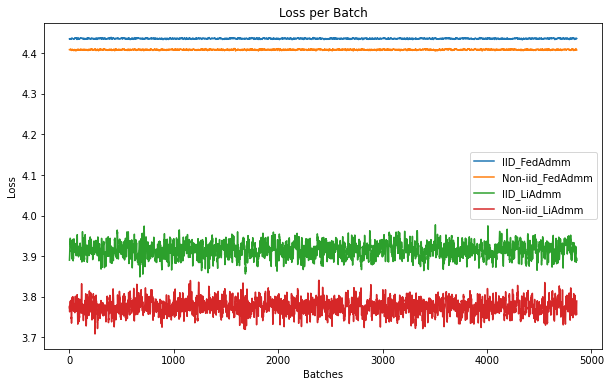

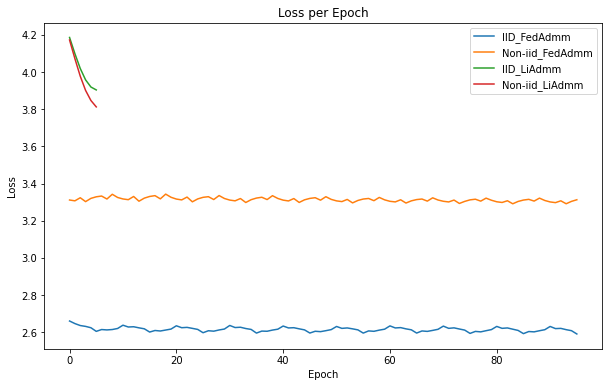

In [95]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(losses_fedadmm_iid , np.ones(5)/5, mode='valid'), label='IID_FedAdmm')
plt.plot(np.convolve(losses_fedadmm_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedAdmm')
plt.plot(np.convolve(losses_liadmm_iid , np.ones(5)/5, mode='valid'), label='IID_LiAdmm')
plt.plot(np.convolve(losses_liadmm_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_LiAdmm')
plt.title('Loss per Batch')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(np.convolve(clients_loss_fedadmm_iid , np.ones(5)/5, mode='valid'), label='IID_FedAdmm')
plt.plot(np.convolve(clients_loss_fedadmm_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedAdmm')
plt.plot(np.convolve(clients_loss_liadmm_iid , np.ones(5)/5, mode='valid'), label='IID_LiAdmm')
plt.plot(np.convolve(clients_loss_liadmm_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_LiAdmm')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

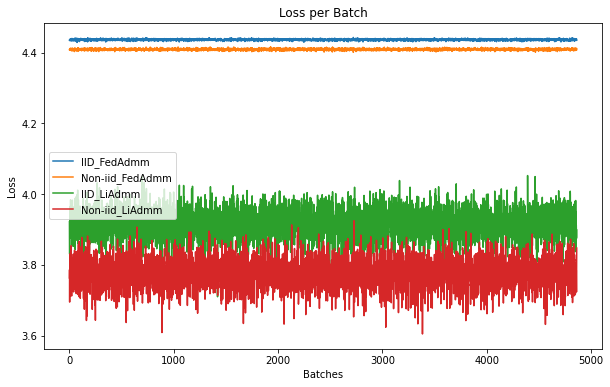

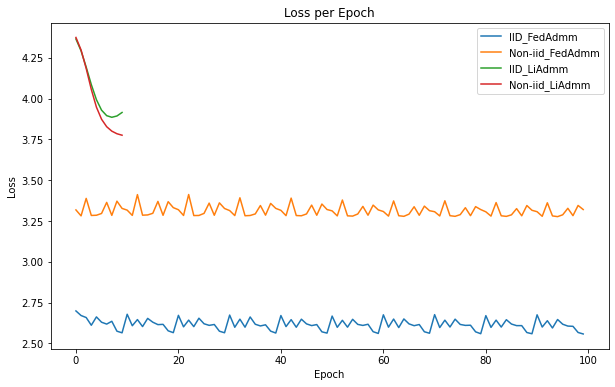

In [96]:
plt.figure(figsize=(10,6))
plt.plot(losses_fedadmm_iid, label='IID_FedAdmm')
plt.plot(losses_fedadmm_noniid, label='Non-iid_FedAdmm')
plt.plot(losses_liadmm_iid, label='IID_LiAdmm')
plt.plot(losses_liadmm_noniid, label='Non-iid_LiAdmm')
plt.title('Loss per Batch')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(clients_loss_fedadmm_iid, label='IID_FedAdmm')
plt.plot(clients_loss_fedadmm_noniid, label='Non-iid_FedAdmm')
plt.plot(clients_loss_liadmm_iid, label='IID_LiAdmm')
plt.plot(clients_loss_liadmm_noniid, label='Non-iid_LiAdmm')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

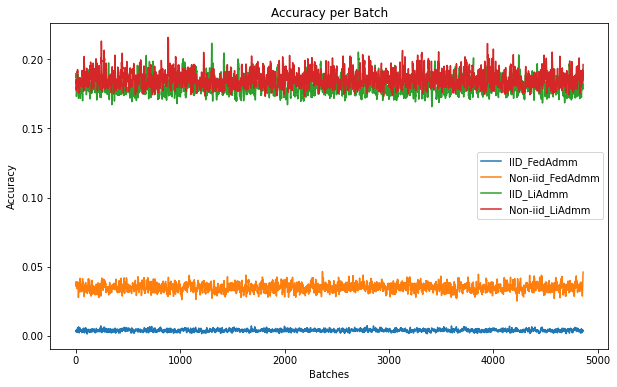

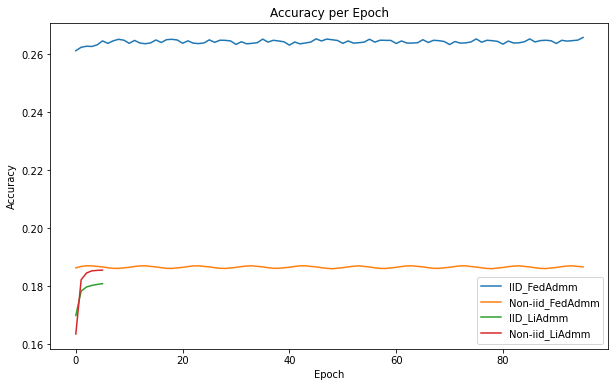

In [97]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(accs_fedadmm_iid , np.ones(5)/5, mode='valid'), label='IID_FedAdmm')
plt.plot(np.convolve(accs_fedadmm_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedAdmm')
plt.plot(np.convolve(accs_liadmm_iid , np.ones(5)/5, mode='valid'), label='IID_LiAdmm')
plt.plot(np.convolve(accs_liadmm_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_LiAdmm')
plt.title('Accuracy per Batch')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(np.convolve(cliets_acc_fedadmm_iid , np.ones(5)/5, mode='valid'), label='IID_FedAdmm')
plt.plot(np.convolve(cliets_acc_fedadmm_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedAdmm')
plt.plot(np.convolve(cliets_acc_liadmm_iid , np.ones(5)/5, mode='valid'), label='IID_LiAdmm')
plt.plot(np.convolve(cliets_acc_liadmm_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_LiAdmm')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

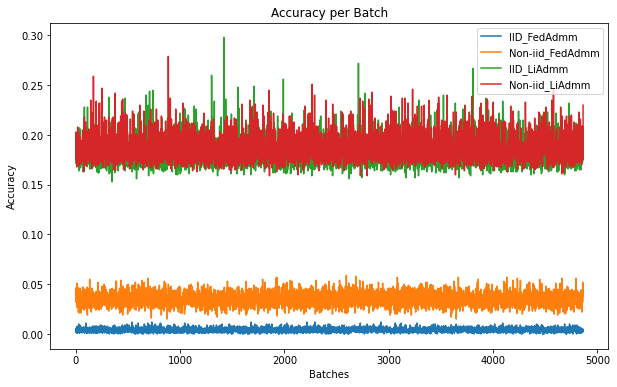

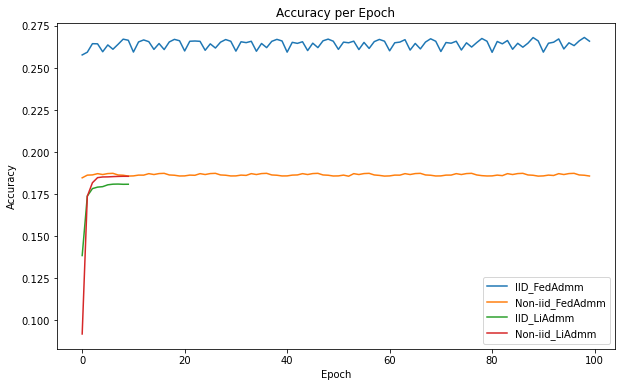

In [98]:
plt.figure(figsize=(10,6))
plt.plot(accs_fedadmm_iid, label='IID_FedAdmm')
plt.plot(accs_fedadmm_noniid, label='Non-iid_FedAdmm')
plt.plot(accs_liadmm_iid, label='IID_LiAdmm')
plt.plot(accs_liadmm_noniid, label='Non-iid_LiAdmm')
plt.title('Accuracy per Batch')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(cliets_acc_fedadmm_iid, label='IID_FedAdmm')
plt.plot(cliets_acc_fedadmm_noniid, label='Non-iid_FedAdmm')
plt.plot(cliets_acc_liadmm_iid, label='IID_LiAdmm')
plt.plot(cliets_acc_liadmm_noniid, label='Non-iid_LiAdmm')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Compare All**

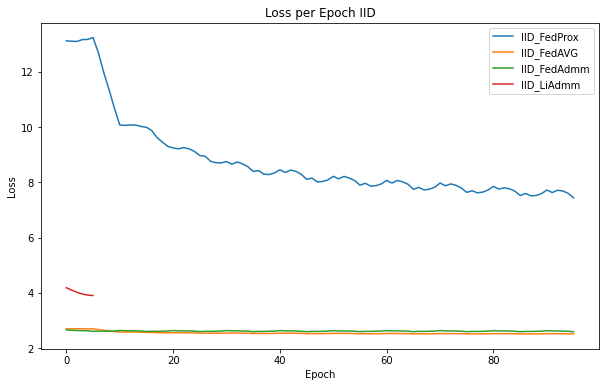

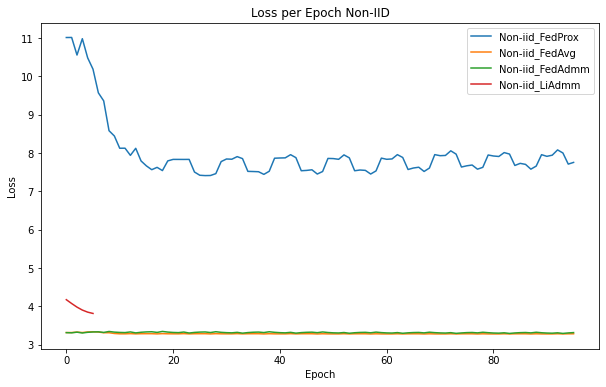

In [99]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(clients_loss_fedprox_iid , np.ones(5)/5, mode='valid'), label='IID_FedProx')
plt.plot(np.convolve(clients_loss_fedavg_iid , np.ones(5)/5, mode='valid'), label='IID_FedAVG')
plt.plot(np.convolve(clients_loss_fedadmm_iid , np.ones(5)/5, mode='valid'), label='IID_FedAdmm')
plt.plot(np.convolve(clients_loss_liadmm_iid , np.ones(5)/5, mode='valid'), label='IID_LiAdmm')
plt.title('Loss per Epoch IID')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(np.convolve(clients_loss_fedprox_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedProx')
plt.plot(np.convolve(clients_loss_fedavg_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedAvg')
plt.plot(np.convolve(clients_loss_fedadmm_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedAdmm')
plt.plot(np.convolve(clients_loss_liadmm_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_LiAdmm')
plt.title('Loss per Epoch Non-IID')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

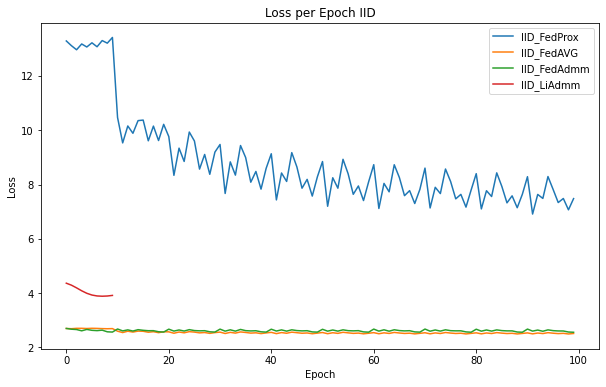

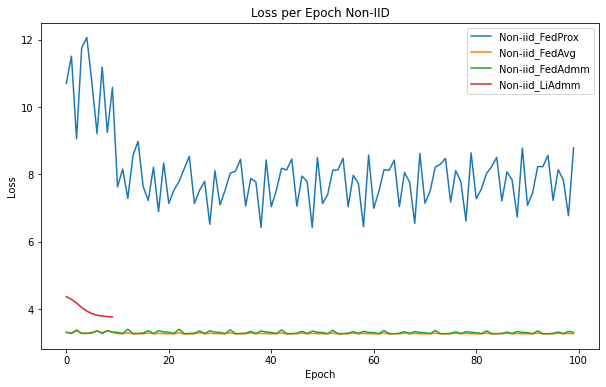

In [100]:
plt.figure(figsize=(10,6))
plt.plot(clients_loss_fedprox_iid, label='IID_FedProx')
plt.plot(clients_loss_fedavg_iid, label='IID_FedAVG')
plt.plot(clients_loss_fedadmm_iid, label='IID_FedAdmm')
plt.plot(clients_loss_liadmm_iid, label='IID_LiAdmm')
plt.title('Loss per Epoch IID')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(clients_loss_fedprox_noniid, label='Non-iid_FedProx')
plt.plot(clients_loss_fedavg_noniid, label='Non-iid_FedAvg')
plt.plot(clients_loss_fedadmm_noniid, label='Non-iid_FedAdmm')
plt.plot(clients_loss_liadmm_noniid, label='Non-iid_LiAdmm')
plt.title('Loss per Epoch Non-IID')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

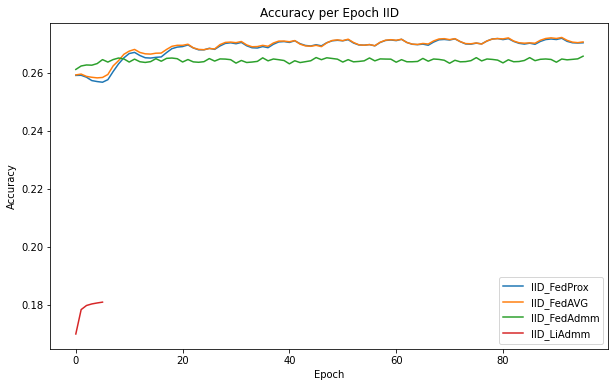

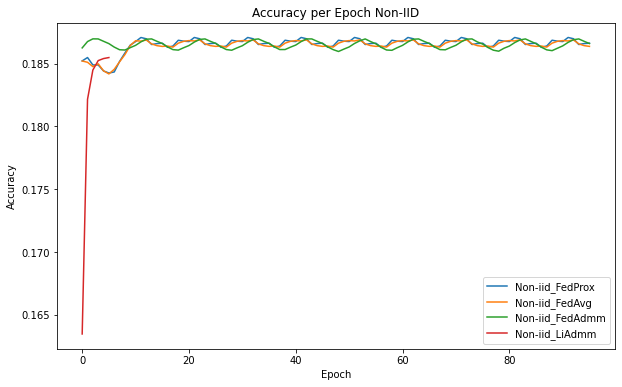

In [101]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(cliets_acc_fedprox_iid , np.ones(5)/5, mode='valid'), label='IID_FedProx')
plt.plot(np.convolve(cliets_acc_fedavg_iid , np.ones(5)/5, mode='valid'), label='IID_FedAVG')
plt.plot(np.convolve(cliets_acc_fedadmm_iid , np.ones(5)/5, mode='valid'), label='IID_FedAdmm')
plt.plot(np.convolve(cliets_acc_liadmm_iid , np.ones(5)/5, mode='valid'), label='IID_LiAdmm')
plt.title('Accuracy per Epoch IID')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(np.convolve(cliets_acc_fedprox_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedProx')
plt.plot(np.convolve(cliets_acc_fedavg_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedAvg')
plt.plot(np.convolve(cliets_acc_fedadmm_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedAdmm')
plt.plot(np.convolve(cliets_acc_liadmm_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_LiAdmm')
plt.title('Accuracy per Epoch Non-IID')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

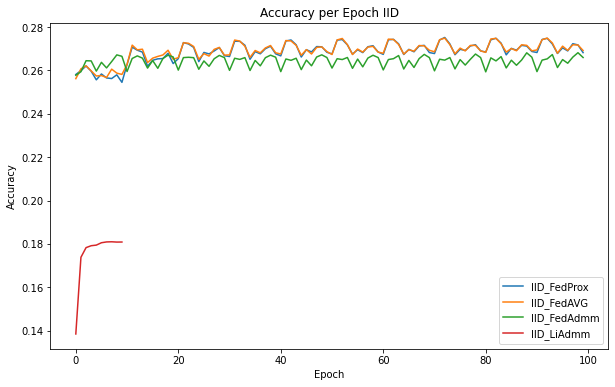

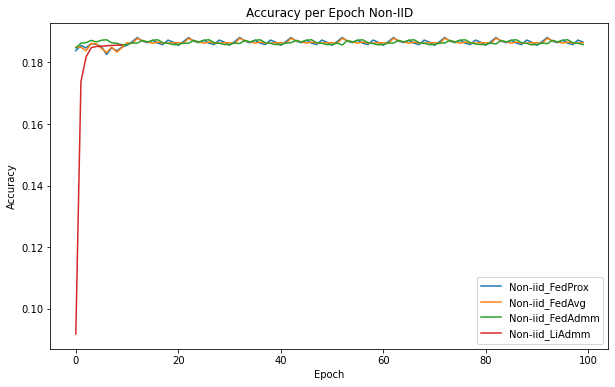

In [102]:
plt.figure(figsize=(10,6))
plt.plot(cliets_acc_fedprox_iid, label='IID_FedProx')
plt.plot(cliets_acc_fedavg_iid, label='IID_FedAVG')
plt.plot(cliets_acc_fedadmm_iid, label='IID_FedAdmm')
plt.plot(cliets_acc_liadmm_iid, label='IID_LiAdmm')
plt.title('Accuracy per Epoch IID')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(cliets_acc_fedprox_noniid, label='Non-iid_FedProx')
plt.plot(cliets_acc_fedavg_noniid, label='Non-iid_FedAvg')
plt.plot(cliets_acc_fedadmm_noniid, label='Non-iid_FedAdmm')
plt.plot(cliets_acc_liadmm_noniid, label='Non-iid_LiAdmm')
plt.title('Accuracy per Epoch Non-IID')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Compare Loss of All models with Centralized**

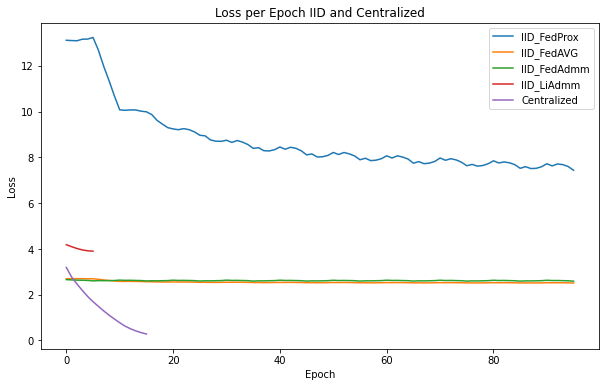

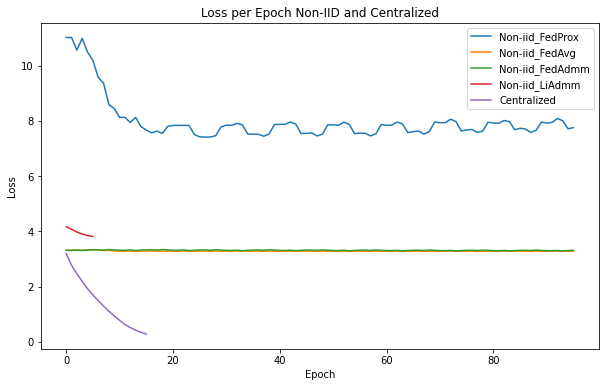

In [103]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(clients_loss_fedprox_iid , np.ones(5)/5, mode='valid'), label='IID_FedProx')
plt.plot(np.convolve(clients_loss_fedavg_iid , np.ones(5)/5, mode='valid'), label='IID_FedAVG')
plt.plot(np.convolve(clients_loss_fedadmm_iid , np.ones(5)/5, mode='valid'), label='IID_FedAdmm')
plt.plot(np.convolve(clients_loss_liadmm_iid , np.ones(5)/5, mode='valid'), label='IID_LiAdmm')
plt.plot(np.convolve(losses_centralized , np.ones(5)/5, mode='valid'), label='Centralized')
plt.title('Loss per Epoch IID and Centralized')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(np.convolve(clients_loss_fedprox_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedProx')
plt.plot(np.convolve(clients_loss_fedavg_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedAvg')
plt.plot(np.convolve(clients_loss_fedadmm_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_FedAdmm')
plt.plot(np.convolve(clients_loss_liadmm_noniid , np.ones(5)/5, mode='valid'), label='Non-iid_LiAdmm')
plt.plot(np.convolve(losses_centralized , np.ones(5)/5, mode='valid'), label='Centralized')
plt.title('Loss per Epoch Non-IID and Centralized')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

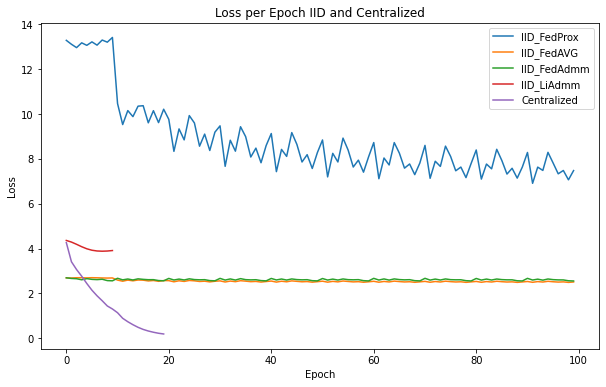

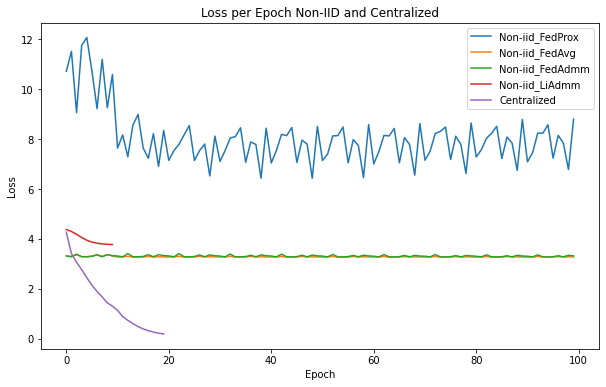

In [104]:
plt.figure(figsize=(10,6))
plt.plot(clients_loss_fedprox_iid, label='IID_FedProx')
plt.plot(clients_loss_fedavg_iid, label='IID_FedAVG')
plt.plot(clients_loss_fedadmm_iid, label='IID_FedAdmm')
plt.plot(clients_loss_liadmm_iid, label='IID_LiAdmm')
plt.plot(losses_centralized, label='Centralized')
plt.title('Loss per Epoch IID and Centralized')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(clients_loss_fedprox_noniid, label='Non-iid_FedProx')
plt.plot(clients_loss_fedavg_noniid, label='Non-iid_FedAvg')
plt.plot(clients_loss_fedadmm_noniid, label='Non-iid_FedAdmm')
plt.plot(clients_loss_liadmm_noniid, label='Non-iid_LiAdmm')
plt.plot(losses_centralized, label='Centralized')
plt.title('Loss per Epoch Non-IID and Centralized')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

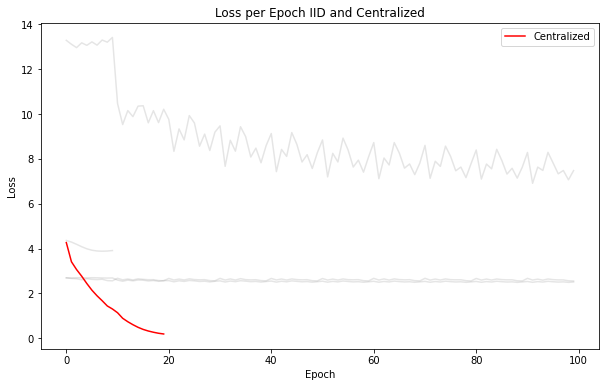

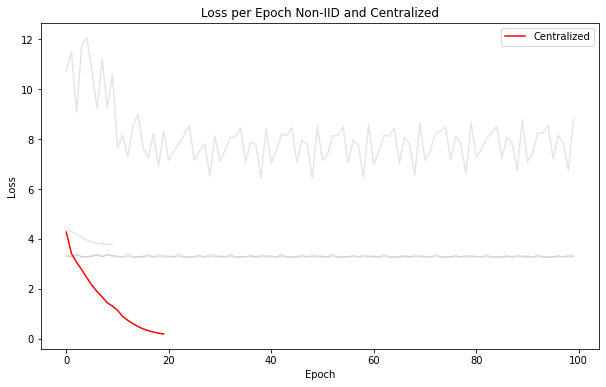

In [105]:
plt.figure(figsize=(10,6))
plt.plot(clients_loss_fedprox_iid,color = 'gray',alpha= 0.2)
plt.plot(clients_loss_fedavg_iid,color = 'gray',alpha= 0.2)
plt.plot(clients_loss_fedadmm_iid,color = 'gray',alpha= 0.2)
plt.plot(clients_loss_liadmm_iid,color = 'gray',alpha= 0.2)
plt.plot(losses_centralized, label='Centralized',color='red')
plt.title('Loss per Epoch IID and Centralized')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(clients_loss_fedprox_noniid,color = 'gray',alpha= 0.2)
plt.plot(clients_loss_fedavg_noniid,color = 'gray',alpha= 0.2)
plt.plot(clients_loss_fedadmm_noniid,color = 'gray',alpha= 0.2)
plt.plot(clients_loss_liadmm_noniid,color = 'gray',alpha= 0.2)
plt.plot(losses_centralized, label='Centralized',color='red')
plt.title('Loss per Epoch Non-IID and Centralized')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()